In [34]:
########################################
#             PATH SETUP
########################################

import sys
import glob
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from pathlib import Path
from collections.abc import Iterable
from typing import Dict
import seaborn as sns
import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [35]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n



def _node_order(scopes: list[str]) -> list[str]:
    """Ordina alfabeticamente i NODE_* (A,B,C,...) per avere pannelli stabili."""
    nodes = [s for s in scopes if isinstance(s, str) and s.startswith("NODE_")]
    return sorted(nodes, key=lambda s: s.replace("NODE_", ""))


def _node_label(scope: str) -> str:
    """Etichetta leggibile per un NODE_*."""
    name = scope.replace("NODE_", "")
    mapping = {"A":"Server A", "B":"Server B", "C":"Server C", "P":"Server P"}
    return mapping.get(name, f"Server {name}")


plt.rcParams.update({
    "figure.figsize": (7.4, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlelocation": "left",
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "legend.frameon": False,
    "lines.linewidth": 2.0,
    "lines.markersize": 5.5,
})
PALETTE = {
    "THEORY": "#1f77b4",   # blu per teoria
    "SIM":    "#ff7f0e",   # arancio per simulazione
    "A":      "#2ca02c",   # verde
    "B":      "#d62728",   # rosso
    "C":      "#000000",   # rosso
    "P":      "#9467bd",   # viola
}

MARKER_POOL = ["o", "s", "^", "D", "v", "P", "X", "*"]  # aggiungi se vuoi
def marker_style_for(index: int, color: str):
    m = MARKER_POOL[index % len(MARKER_POOL)]
    # ogni “giro” della lista alterna pieno/vuoto per aumentare la varietà
    hollow = (index // len(MARKER_POOL)) % 2 == 1
    return dict(
        marker=m, markersize=6.5,
        markerfacecolor=("white" if hollow else color),
        markeredgecolor=color, markeredgewidth=1.8,
    )



BASE_DIR = ".output_simulation"

# configurazione all'inizio del notebook
OBJ = 1   # scegli 1, 2 o 3

# costruisco dinamicamente il nome del file
config_file = f"obj{OBJ}.json"

TITLE_PREFIX = f"OBJ{OBJ}"



In [36]:

# ================== DISCOVERY / LOAD ==================

def find_csv_for_config(config_path: str, base_dir=BASE_DIR, target="results") -> List[str]:
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"{target}_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))




def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df


# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

# ================== PLOTTING (Torkin-like) ==================


In [37]:
conv_files=find_csv_for_config(config_file,target="conv")


In [38]:
##########helper per grafici con intervallo confidenza
# ============================================================
# Overlay teorico dinamico + stima automatica dei μ dai CSV
# Funziona con nodi arbitrari (A,B,P / A,B,C,P / ...).
# Richiede: arrival_rate, mean_population, std_population.
# Opzionale ma consigliato: utilization (per stimare μ).
# Commenti solo in italiano.
# ============================================================

import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- util base ----------

def _z_value(conf: float = 0.95) -> float:
    """Valore critico z della Normale standard per il livello di confidenza."""
    if abs(conf - 0.95) < 1e-12:
        return 1.959963984540054
    lookup = {0.90: 1.6448536269514722, 0.95: 1.959963984540054, 0.975: 2.241402727604947, 0.99: 2.5758293035489004}
    return lookup.get(conf, 1.959963984540054)

def _pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    """Trova la prima colonna disponibile tra i candidati (case-insensitive)."""
    lowmap = {c.lower().strip(): c for c in df.columns}
    for name in candidates:
        key = name.lower().strip()
        if key in lowmap:
            return lowmap[key]
    return None

def _standardize_cols_inplace(df: pd.DataFrame) -> None:
    """Rende lo schema uniforme (rinomina colonne ai nomi canonici)."""
    scope_col = _pick_col(df, ["vscope", "scope", "node", "station", "component"])
    rate_col  = _pick_col(df, ["arrival_rate", "lambda", "lam", "arr_rate"])
    mean_col  = _pick_col(df, ["mean_population", "mean_pop", "avg_population", "population_mean", "E[N]", "meanN"])
    std_col   = _pick_col(df, ["std_population", "std_pop", "population_std", "sd_population", "sigma_population"])
    util_col  = _pick_col(df, ["utilization", "rho", "usage"])  # opzionale ma utile per la stima di μ

    if scope_col is None: raise ValueError(f"Colonna di scope non trovata. Presenti: {list(df.columns)}")
    if rate_col  is None: raise ValueError(f"Colonna 'arrival_rate' non trovata. Presenti: {list(df.columns)}")
    if mean_col  is None: raise ValueError(f"Colonna 'mean_population' non trovata. Presenti: {list(df.columns)}")
    if std_col   is None: raise ValueError(f"Colonna 'std_population' non trovata. Presenti: {list(df.columns)}")

    ren = {scope_col: "vscope", rate_col: "arrival_rate", mean_col: "mean_population", std_col: "std_population"}
    if util_col: ren[util_col] = "utilization"
    df.rename(columns=ren, inplace=True)

def _normalize_scope_values_inplace(df: pd.DataFrame) -> None:
    """Uniforma i valori di scope a OVERALL e NODE_<X>."""
    df["vscope"] = df["vscope"].astype(str).str.strip().str.upper()
    df["vscope"] = df["vscope"].replace({"SYSTEM": "OVERALL", "TOTAL": "OVERALL", "ALL": "OVERALL"})
    df["vscope"] = df["vscope"].str.replace("NODE-", "NODE_", regex=False)
    mask_letter = df["vscope"].str.fullmatch(r"[A-Z]")
    df.loc[mask_letter, "vscope"] = "NODE_" + df.loc[mask_letter, "vscope"]

def _load_one(x) -> pd.DataFrame:
    """Carica un DF o un CSV e applica normalizzazioni."""
    if isinstance(x, pd.DataFrame):
        df = x.copy()
    elif isinstance(x, (str, pathlib.Path)):
        df = pd.read_csv(x, na_values=["-", "-,-"])
    else:
        raise TypeError(f"Tipo non supportato: {type(x)}")
    _standardize_cols_inplace(df)
    _normalize_scope_values_inplace(df)
    # tipi numerici
    for c in ["arrival_rate", "mean_population", "std_population", "utilization"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _ensure_df(files_or_path) -> pd.DataFrame:
    """Accetta DF / path / lista/tupla di DF o path e concatena tutto."""
    if isinstance(files_or_path, (list, tuple)):
        parts = [_load_one(it) for it in files_or_path]
        df = pd.concat(parts, ignore_index=True, sort=False)
    else:
        df = _load_one(files_or_path)
    return df

def _detect_nodes(df: pd.DataFrame) -> list[str]:
    """Estrae i nomi dei nodi presenti (NODE_<X>)."""
    mask = df["vscope"].str.startswith("NODE_")
    return sorted([v.split("NODE_")[1] for v in df.loc[mask, "vscope"].unique().tolist()])

# ---------- CI e modello ----------

def ci_from_files(files_or_path, scope: str, n_rep: int, conf: float = 0.95) -> pd.DataFrame:
    """Media e semi-ampiezza IC per uno scope (OVERALL o NODE_<X>)."""
    df = _ensure_df(files_or_path)
    sub = df[df["vscope"] == scope].copy().sort_values("arrival_rate")
    if sub.empty:
        raise ValueError(f"Nessuna riga per scope '{scope}'. Scopes: {sorted(df['vscope'].unique())}")
    z = _z_value(conf)
    mean = sub["mean_population"].to_numpy(float)
    std  = sub["std_population"].to_numpy(float)
    ci   = z * std / math.sqrt(float(n_rep))
    return pd.DataFrame({"arrival_rate": sub["arrival_rate"].to_numpy(float), "mean": mean, "ci": ci})

def analytic_mean_populations_generic(arrival_rates: np.ndarray,
                                      mu: dict[str, float],
                                      visits: dict[str, int]) -> pd.DataFrame:
    """Modello M/M/1 per ciascun nodo + SYSTEM (dinamico)."""
    γ = np.asarray(arrival_rates, dtype=float)
    nodes = sorted(set(mu.keys()) & set(visits.keys()))

    def mm1(lam, mu_i):
        rho = lam / mu_i
        mask = rho < 1.0 - 1e-12
        N = np.full_like(lam, np.nan, float)
        T = np.full_like(lam, np.nan, float)
        N[mask] = lam[mask] / (mu_i - lam[mask])
        T[mask] = 1.0 / (mu_i - lam[mask])
        return N, T

    cols, Tsum = {"arrival_rate": γ}, np.zeros_like(γ, float)
    for n in nodes:
        lam_n = visits[n] * γ
        Nn, Tn = mm1(lam_n, float(mu[n]))
        cols[n] = Nn
        Tsum += visits[n] * Tn
    cols["SYS"] = γ * Tsum
    return pd.DataFrame(cols)

# ---------- stima automatica dei μ (opzionale ma comoda) ----------

def estimate_mu_from_files(files_or_path, visits: dict[str, int],
                           max_util: float = 0.7) -> dict[str, float]:
    """
    Stima μ_n per ogni nodo usando μ ≈ (v_n * γ) / ρ_n misurata.
    Usa solo punti a basso carico (utilization < max_util) per evitare distorsioni.
    Se manca 'utilization', solleva un errore esplicativo.
    """
    df = _ensure_df(files_or_path)
    if "utilization" not in df.columns:
        raise ValueError("Non trovo la colonna 'utilization' nei dati; passa μ a mano via mu_params.")
    nodes = _detect_nodes(df)
    mu_hat = {}
    for n in nodes:
        v = int(visits.get(n, 1))
        sub = df[df["vscope"] == f"NODE_{n}"].dropna(subset=["arrival_rate", "utilization"]).copy()
        sub = sub[(sub["utilization"] > 0) & (sub["utilization"] < max_util)]
        if sub.empty:
            # fallback: prendi i 3 lambda più piccoli disponibili
            sub = df[df["vscope"] == f"NODE_{n}"].nsmallest(3, "arrival_rate")
        mu_hat[n] = float(np.median((v * sub["arrival_rate"]) / sub["utilization"]))
    return mu_hat

# ---------- plotting dinamico con overlay ----------

def plot_finite_population_dynamic(files_or_path,
                                   n_rep: int,
                                   conf: float = 0.95,
                                   mu_params: dict[str, float] | None = None,
                                   visits: dict[str, int] | None = None,
                                   node_order: list[str] | None = None,
                                   cols: int = 2,
                                   figsize=(12, 9),
                                   savepath: str | None = None,
                                    show_xticks_all: bool = True):  # <-- aggiunto
    
    """
    Pannelli dinamici: SYSTEM + uno per ciascun nodo trovato nei dati.
    Se mu_params+visits sono forniti, mostra anche la curva teorica.
    """
    df = _ensure_df(files_or_path)
    lambdas = np.sort(df["arrival_rate"].dropna().unique())
    detected = _detect_nodes(df)
    nodes = ( [n for n in node_order if n in detected] + [n for n in detected if not node_order or n not in node_order]
             ) if node_order else detected

    # CI simulazione
    ci_sys = ci_from_files(df, "OVERALL", n_rep, conf)
    ci_nodes = {n: ci_from_files(df, f"NODE_{n}", n_rep, conf) for n in nodes}

    # Curva analitica opzionale
    model = None
    if mu_params is not None and visits is not None:
        model = analytic_mean_populations_generic(lambdas, mu=mu_params, visits=visits)

    # layout
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    fig.suptitle("Confidence interval for average population", y=0.98)

    # SYSTEM
    ax = axs[0]
    ax.errorbar(ci_sys["arrival_rate"], ci_sys["mean"], yerr=ci_sys["ci"], fmt="o-", label="simulation run")
    if model is not None and "SYS" in model.columns:
        ax.plot(model["arrival_rate"], model["SYS"], label="analytical model")
    ax.set_title("Confidence interval for SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM"); ax.legend()

    # NODI
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = ci_nodes[n]
        ax.errorbar(d["arrival_rate"], d["mean"], yerr=d["ci"], fmt="o-", label="simulation run")
        if model is not None and n in model.columns:
            ax.plot(model["arrival_rate"], model[n], label="analytical model")
        ax.set_title(f"Confidence interval for {n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        ax.legend()

    # nascondi assi extra
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)


    if show_xticks_all:
        # forza la visualizzazione delle etichette X su TUTTI i pannelli
        for ax in axs:
            ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [39]:
# === Utilities mancanti per plot_system_rt ===
import numpy as np
import pandas as pd
import math

def estimate_demands_from_df(df_all: pd.DataFrame) -> dict:
    """
    Stima i service demand D_j di ciascun nodo usando l'identità ρ_j = X * D_j.
    - X è il throughput medio OVERALL.
    - Per ogni NODE_* prende la media di 'utilization' e fa D_j = rho_j / X.
    Ritorna un dict con chiavi 'D_<NODE>' e campi di servizio:
      - 'bottleneck': la chiave del nodo col D_j massimo (es. 'D_B')
      - 'X_sat'    : 1 / max(D_j) (asintoto verticale teorico)
    """
    if df_all.empty:
        raise ValueError("df_all è vuoto")

    df_overall = df_all[df_all["scope"] == "OVERALL"]
    df_nodes   = df_all[df_all["scope"].astype(str).str.startswith("NODE_")]

    if "throughput" not in df_overall.columns:
        raise KeyError("Manca la colonna 'throughput' in OVERALL")

    X = float(df_overall["throughput"].mean())
    if X <= 0 or not math.isfinite(X):
        raise ValueError(f"Throughput OVERALL non valido: {X}")

    out = {}
    for scope, grp in df_nodes.groupby("scope"):
        if "utilization" not in grp.columns or grp["utilization"].dropna().empty:
            continue
        rho = float(grp["utilization"].mean())
        node_name = scope.replace("NODE_", "")  # es. "A", "B", "P"
        out[f"D_{node_name}"] = rho / X

    if not out:
        raise ValueError("Non ho trovato NODE_* con 'utilization' per stimare i demand")

    # individua il bottleneck e calcola X_sat
    bneck_key = max(out, key=out.get)  # 'D_<NODE>' col valore massimo
    Dmax = out[bneck_key]
    out["bottleneck"] = bneck_key
    out["X_sat"] = 1.0 / Dmax if Dmax > 0 else float("inf")
    return out

from scipy.stats import t as student_t

def aggregate_sim_overall(df_overall: pd.DataFrame,
                          *,
                          x_candidates=("arrival_rate", "throughput", "x"),
                          mean_col="mean_response_time",
                          # se presenti: colonna id replica e colonna n_departures
                          rep_candidates=("rep", "seed", "run", "iteration", "trial", "rep_id", "batch"),
                          n_departures_candidates=("num_departures","departures","n_departures"),
                          conf=0.95,
                          fallback_design_effect=8.0):
    """
    Aggrega OVERALL per λ con media e IC 95%:
    - Se ci sono più righe per λ (o una colonna 'rep'), fa IC *tra repliche* (consigliato).
    - Se per λ c'è una sola riga (dataset già collassato), evita di usare n_departures in modo ingenuo.
      In fallback usa la var tra 'repliche' se presente, altrimenti allarga in modo controllato
      con un 'design effect' (>1) sulla std intra-run (esplicita e modificabile).

    Ritorna:
      agg: DataFrame con colonne [xcol, 'mean', 'ci_lo', 'ci_hi']
      xcol: nome della colonna X usata
      xlabel: etichetta per asse X
    """
    df = df_overall.copy()

    # 1) scegli la X (λ normalmente)
    xcol = None
    for c in x_candidates:
        if c in df.columns:
            xcol = c
            break
    if xcol is None:
        raise ValueError(f"Nessuna colonna X tra {x_candidates} in df_overall.columns={list(df.columns)}")

    # 2) trova colonna id-replica se esiste
    rep_col = None
    for c in rep_candidates:
        if c in df.columns:
            rep_col = c
            break

    # 3) trova colonna n_departures (solo per fallback, NON per IC by-rep)
    ndep_col = None
    for c in n_departures_candidates:
        if c in df.columns:
            ndep_col = c
            break

    records = []
    for lam, g in df.groupby(xcol, sort=True):
        vals = pd.to_numeric(g[mean_col], errors="coerce").dropna()
        R = len(vals) if rep_col or len(g) > 1 else 1

        if R > 1:
            # >>> IC *tra repliche* (consigliato) <<<
            m = float(vals.mean())
            s = float(vals.std(ddof=1)) if R > 1 else 0.0
            tcrit = float(student_t.ppf(0.5 + conf/2.0, max(R-1, 1)))
            half = tcrit * s / math.sqrt(R)
            lo, hi = m - half, m + half
        else:
            # >>> Fallback (dataset già collassato per λ) <<<
            # NON usiamo n_departures "puri" (correlazione seriale); invece esplicitiamo un design effect.
            m = float(vals.iloc[0]) if len(vals) else np.nan
            # std intra-run, se c'è
            std_run = None
            for c in ("std_response_time", "std_rt", "std"):
                if c in g.columns and pd.notna(g[c].iloc[0]):
                    std_run = float(g[c].iloc[0]); break

            if std_run is None:
                # non posso costruire un IC credibile -> barra nulla
                lo, hi = m, m
            else:
                # n_eff = n_departures / design_effect (default 8: prudente in presenza di correlazione)
                n_eff = None
                if ndep_col and pd.notna(g[ndep_col].iloc[0]):
                    n_eff = max(1.0, float(g[ndep_col].iloc[0]) / float(fallback_design_effect))
                else:
                    n_eff = 1.0  # ultra-conservativo
                z = _z_value(conf)
                half = z * std_run / math.sqrt(n_eff)
                lo, hi = m - half, m + half

        records.append({xcol: float(lam), "mean": m, "ci_lo": lo, "ci_hi": hi})

    agg = pd.DataFrame(records).sort_values(xcol)
    xlabel = "Arrival Rate (λ)" if xcol == "arrival_rate" else xcol
    return agg, xcol, xlabel


def theoretical_R(x, demands):
    x = np.asarray(x, dtype=float)
    Ds = [v for k,v in demands.items() if isinstance(k,str) and k.startswith("D_")]
    R = np.zeros_like(x, dtype=float)
    for Dj in Ds:
        R += Dj / (1.0 - x * Dj)
    X_sat = 1.0 / max(Ds)
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)
    valid = (x <= X_sat - eps)
    R = np.where(valid & np.isfinite(R) & (R > 0), R, np.nan)
    return R


In [40]:

###############

def per_job_covariance(base_dir=BASE_DIR):
    files = glob.glob(os.path.join(base_dir, "per_job_times*.csv"))
    if not files:
        print("Nessun per_job_times*.csv")
        return

    df = pd.concat([pd.read_csv(p) for p in files], ignore_index=True)

    # prendi dinamicamente tutte le colonne T_*
    cols = [c for c in df.columns if c.startswith("T_")]
    if len(cols) < 2:
        print("per_job_times ha meno di 2 colonne T_*")
        return

    # calcola covariance e correlation solo sulle colonne trovate
    cov = df[cols].cov()
    corr = df[cols].corr()

    print("Colonne trovate:", cols)
    print("\nCovariance matrix:\n", cov.round(5))
    print("\nCorrelation matrix:\n", corr.round(4))

# esempio di chiamata
per_job_covariance()



Nessun per_job_times*.csv


In [41]:
# Sanity check
files = find_csv_for_config(config_file, base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

CSV trovati: 5
 - .output_simulation\results_obj1_arrivals_run000_seed314159265_20250827_103122.csv
 - .output_simulation\results_obj1_arrivals_run015_seed1899032171_20250827_103216.csv
 - .output_simulation\results_obj1_arrivals_run030_seed1463093617_20250827_103312.csv
 - .output_simulation\results_obj1_arrivals_run045_seed779946103_20250827_103409.csv
 - .output_simulation\results_obj1_arrivals_run060_seed673620713_20250827_103506.csv


In [42]:
def plot_system_rt(df_all: pd.DataFrame,
                   *,
                   width: float = 9.5,
                   height: float = 4.8,
                   dpi: int = 130,
                   show_theory: bool = True,
                   zoom_range: tuple[float, float] | None = None,
                   x_overview_cap: float = 1.6,
                   right_pad_ratio: float = 0.06,
                   y_cap_overview: float | None = None,
                   y_cap_zoom: float | None = None,
                   percentile_cap: float = 95.0,    # più stretto dell’originale 99
                   ci_conf: float = 0.95,           # NOVITÀ: confidenza IC
                   ci_design_effect: float = 12.0,  # NOVITÀ: usato solo se R=1
                   ci_fill: bool = True,            # NOVITÀ: banda CI
                   min_display_half: float = 0.0    # NOVITÀ: half-width minimo SOLO VISUALE
                   ):
    """
    SYSTEM: simulazione (media ± CI) + curva teorica opzionale.
    - Se zoom_range=(x0,x1): due pannelli con assi X INDIPENDENTI.
    - Mostra l’asintoto verticale a X_sat.
    - 'min_display_half' NON modifica i calcoli: serve solo a non perdere le barre a schermo.
    """

    # --- 1) stima demand + X_sat ---
    D = estimate_demands_from_df(df_all)
    X_sat = float(D["X_sat"])
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)

    # --- 2) OVERALL (mean ± CI tra repliche se R>1) ---
    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time.")
        return
    agg, xcol, xlabel = aggregate_sim_overall(
        df_overall,
        conf=ci_conf,
        fallback_design_effect=ci_design_effect
    )

    # --- helper: media + CI (con banda + whiskers) ---
    def draw_mean_ci(ax, agg_df, *, color, label_mean="Simulazione (mean)"):
        x  = agg_df[xcol].to_numpy(float)
        mu = agg_df["mean"].to_numpy(float)
        lo = np.where(np.isfinite(agg_df["ci_lo"]), agg_df["ci_lo"].to_numpy(float), mu)
        hi = np.where(np.isfinite(agg_df["ci_hi"]), agg_df["ci_hi"].to_numpy(float), mu)

        # SOLO estetica: assicura una half-width minima a schermo
        if min_display_half > 0:
            half = np.maximum(0.5*(hi - lo), float(min_display_half))
            lo = mu - half
            hi = mu + half

        # banda CI (aiuta molto a "vederla")
        if ci_fill:
            ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)

        # linea + marker
        ax.plot(x, mu, "o-", color=color, linewidth=2.3, zorder=3, label=label_mean)

        # whiskers evidenti
        yerr = np.vstack([mu - lo, hi - mu])
        ax.errorbar(x, mu, yerr=yerr, fmt="none", ecolor="black",
                    elinewidth=2.6, capsize=6, zorder=4, label="CI 95%")
        return x, mu, lo, hi

    # --- 3) range X dei dati + estensione dinamica per l’overview ---
    xmin_data, xmax_data = float(np.nanmin(agg[xcol])), float(np.nanmax(agg[xcol]))
    x_overview_min = xmin_data if zoom_range is None else min(xmin_data, zoom_range[0])
    x_target_max = max(xmax_data, (zoom_range[1] if zoom_range else xmax_data), X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- 4) curva teorica (mascherata a destra di X_sat) ---
    def theory_masked(xgrid: np.ndarray) -> np.ndarray:
        y = theoretical_R(xgrid, D) if show_theory else None
        if y is None: return None
        mask = (xgrid <= X_sat - eps) & np.isfinite(y) & (y > 0)
        return np.where(mask, y, np.nan)

    grid_over = np.linspace(max(1e-6, x_overview_min*0.98), x_overview_max, 1500)
    R_over = theory_masked(grid_over)

    # === CASO A: solo overview ===
    if zoom_range is None:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        if show_theory:
            ax.plot(grid_over, R_over, color=PALETTE["THEORY"],
                    label="Teoria (M/M/1 in serie)", zorder=0)
        _, mu, lo, hi = draw_mean_ci(ax, agg, color=PALETTE["SIM"])

        if x_overview_min <= X_sat <= x_overview_max:
            ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.85,
                       linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

        # auto-cap per non schiacciare le CI
        if y_cap_overview is None:
            pool = [mu, lo, hi]; 
            if R_over is not None: pool.append(R_over)
            vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None])
            if vals.size:
                cap = np.nanpercentile(vals, percentile_cap) * 1.05
                y_cap_overview = float(cap) if np.isfinite(cap) else None
        ax.set_ylim(bottom=0, top=y_cap_overview)

        ax.set_xlim(x_overview_min, x_overview_max)
        ax.set_xlabel(xlabel); ax.set_ylabel("Mean Response Time (s)")
        ax.set_title(f"{TITLE_PREFIX} — SYSTEM: teoria vs simulazione")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(loc="upper left"); plt.tight_layout(); plt.show(); return

    # === CASO B: overview + zoom ===
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height * 1.35), dpi=dpi,
                                   gridspec_kw={"height_ratios": [2, 1]})

    if show_theory:
        ax1.plot(grid_over, R_over, color=PALETTE["THEORY"],
                 label="Teoria (M/M/1 in serie)", zorder=0)
    _, mu_o, lo_o, hi_o = draw_mean_ci(ax1, agg, color=PALETTE["SIM"])

    if x_overview_min <= X_sat <= x_overview_max:
        ax1.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label=f"X_sat ≈ {X_sat:.3f}", zorder=5)

    import matplotlib.patches as patches
    y0, y1 = ax1.get_ylim()
    rect = patches.Rectangle((zoom_range[0], y0), zoom_range[1]-zoom_range[0],
                             (y1 - y0)*0.06, facecolor="none",
                             edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6)
    ax1.add_patch(rect)

    ax1.set_xlim(x_overview_min, x_overview_max)
    ax1.set_ylabel("Mean Response Time (s)")
    ax1.set_title(f"{TITLE_PREFIX} — SYSTEM: overview + zoom")
    ax1.grid(True, linestyle="--", alpha=0.35); ax1.legend(loc="upper left")

    grid_z = np.linspace(zoom_range[0], zoom_range[1], 1200)
    R_zoom = theory_masked(grid_z)
    if show_theory:
        ax2.plot(grid_z, R_zoom, color=PALETTE["THEORY"], linewidth=2.0, alpha=0.85)
    _, mu_z, lo_z, hi_z = draw_mean_ci(ax2, agg, color=PALETTE["SIM"])

    if zoom_range[0] <= X_sat <= zoom_range[1]:
        ax2.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0)

    ax2.set_xlim(*zoom_range)
    ax2.set_xlabel(xlabel); ax2.set_ylabel("Time (s)")
    ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax2.grid(True, linestyle="--", alpha=0.35)

    if y_cap_overview is None:
        pool_o = [mu_o, lo_o, hi_o]; 
        if R_over is not None: pool_o.append(R_over)
        vals_o = np.hstack([p[np.isfinite(p)] for p in pool_o if p is not None])
        if vals_o.size:
            y_cap_overview = float(np.nanpercentile(vals_o, percentile_cap) * 1.05)
    if y_cap_zoom is None:
        pool_z = [mu_z, lo_z, hi_z]; 
        if R_zoom is not None: pool_z.append(R_zoom)
        vals_z = np.hstack([p[np.isfinite(p)] for p in pool_z if p is not None])
        if vals_z.size:
            y_cap_zoom = float(np.nanpercentile(vals_z, percentile_cap) * 1.05)

    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    from matplotlib.ticker import MaxNLocator
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=8))

    plt.tight_layout(); plt.show()


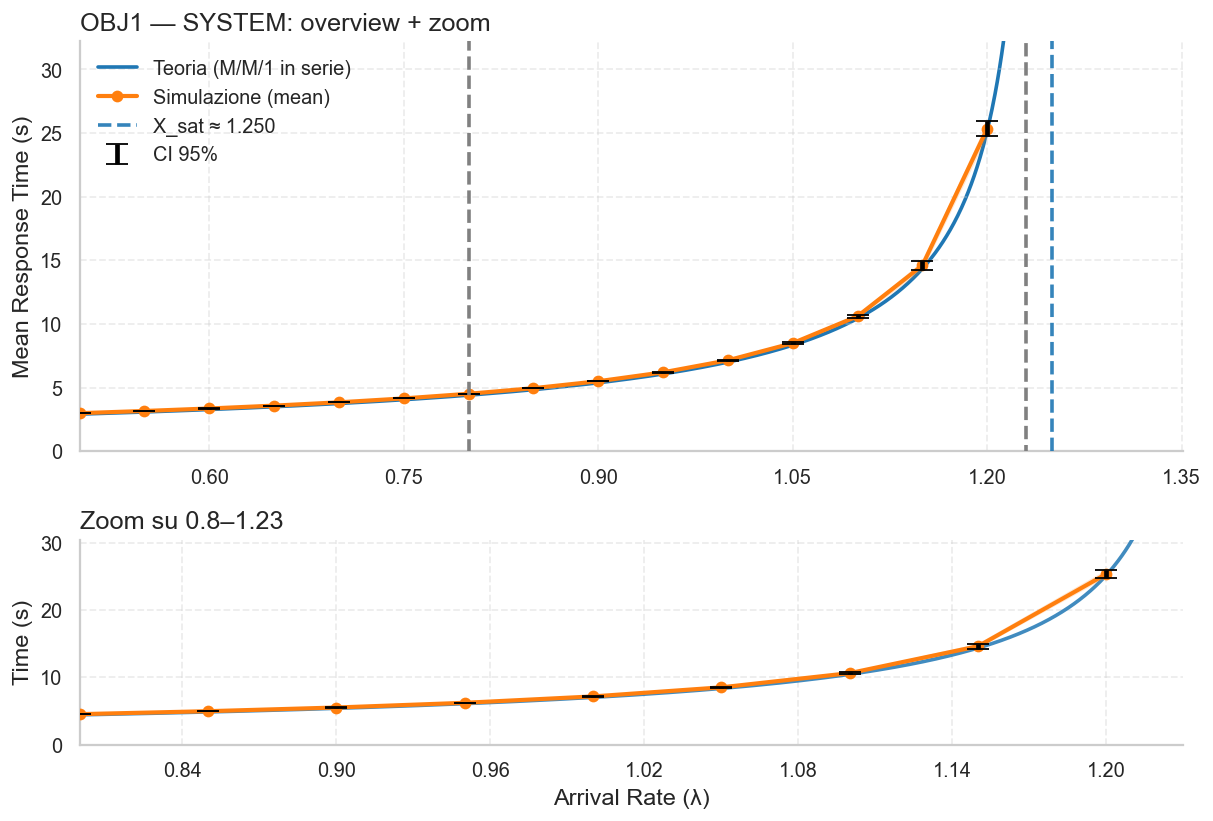

In [43]:
# SYSTEM con zoom sulla coda verso saturazione
df_all = load_runs(files)

plot_system_rt(df_all, zoom_range=(0.8, 1.23)) #usare questo per obj1 e 2 
#plot_system_rt(df_all, zoom_range=(1.21, 1.43)) #usare questo per obj3



In [44]:
# ============================================================
# ADD-ON: banda CI in stile plot_system_rt per la POPOLATION
# - Banda "fill_between" + whiskers (mean ± CI)
# - Half-width minimo SOLO VISUALE
# - Design effect se hai una sola replica (R=1)
# Requisiti: funzioni _ensure_df, _detect_nodes, _z_value già presenti
# ============================================================

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd


def _collapse_by_lambda(ci_df, how: str = "mean"):
    """
    Prende un DF con colonne: arrival_rate, mean, half
    e restituisce un DF con una sola riga per ogni arrival_rate.
    how="mean" -> media delle colonne; "max" o "min" opzionali.
    """
    if how == "mean":
        agg = {"mean": "mean", "half": "mean"}
    elif how == "max":
        agg = {"mean": "mean", "half": "max"}   # media della media, CI più conservativo
    elif how == "min":
        agg = {"mean": "mean", "half": "min"}
    else:
        raise ValueError("how must be 'mean', 'max' or 'min'")

    out = (ci_df.groupby("arrival_rate", as_index=False)
                 .agg(agg)
                 .sort_values("arrival_rate")
                 .reset_index(drop=True))
    return out
# --- piccolo helper per palette opzionale (riusa PALETTE se esiste) ---
def _pal(key, default):
    try:
        return PALETTE[key]  # noqa: F821
    except Exception:
        return default

# --- disegno stile "plot_system_rt": banda + whiskers ---
# PATCH: estendi _draw_ci_banded con 'errorevery' per diradare le barre
# FIX: sostituisci la definizione di _draw_ci_banded con questa
def _draw_ci_banded(ax, x, mean, half, *, color, label_mean="simulation run",
                    label_ci="CI 95%", min_display_half=0.0, ci_fill=True,
                    errorevery=None):
    import numpy as np
    x = np.asarray(x, float); mu = np.asarray(mean, float)
    h  = np.maximum(np.asarray(half, float), 0.0)

    # solo estetica: half minima
    if min_display_half > 0:
        h = np.maximum(h, float(min_display_half))

    lo, hi = mu - h, mu + h

    if ci_fill:
        ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)

    # linea media
    ax.plot(x, mu, "o-", color=color, linewidth=2.3, zorder=3,
            markevery=max(1, len(x)//40))

    # whiskers: passa 'errorevery' SOLO se è un int >= 2
    yerr = np.vstack([mu - lo, hi - mu])
    eb_kwargs = dict(fmt="none", ecolor="black", elinewidth=2.6, capsize=6, zorder=4, label=label_ci)
    if isinstance(errorevery, (int, np.integer)) and errorevery >= 2:
        eb_kwargs["errorevery"] = int(errorevery)

    ax.errorbar(x, mu, yerr=yerr, **eb_kwargs)
    return lo, hi



# --- CI (half-width) a partire dai tuoi CSV: usa design effect se R=1 ---
def _ci_half_from_df(df_scope, *, n_rep: int, conf: float, ci_design_effect: float) -> pd.DataFrame:
    """
    df_scope: DataFrame già filtrato per uno scope (OVERALL o NODE_*)
              con colonne: arrival_rate, mean_population, std_population
    Ritorna: DataFrame con arrival_rate, mean, half (semi-ampiezza CI)
    """
    z = _z_value(conf)
    out = (df_scope
           .sort_values("arrival_rate")[["arrival_rate", "mean_population", "std_population"]]
           .rename(columns={"mean_population": "mean", "std_population": "std"})
           .copy())
    if n_rep > 1:
        out["half"] = z * out["std"] / math.sqrt(float(n_rep))
    else:
        # fallback R=1: std * sqrt(design effect) (campioni correlati)
        out["half"] = z * out["std"] * math.sqrt(float(ci_design_effect))
    return out

# --- versione "banded" del tuo plot dinamico sulla population ---
def plot_finite_population_dynamic_banded(files_or_path,
                                          *,
                                          n_rep: int,
                                          conf: float = 0.95,
                                          ci_design_effect: float = 12.0,
                                          ci_fill: bool = True,
                                          min_display_half: float = 0.0,
                                          mu_params: dict[str, float] | None = None,
                                          visits: dict[str, int] | None = None,
                                          node_order: list[str] | None = None,
                                          cols: int = 2,
                                          figsize=(12, 9),
                                          savepath: str | None = None,
                                          show_xticks_all: bool = True,
                                          title: str = "Confidence interval for average population"):
    """
    Identico a plot_finite_population_dynamic ma con CI in stile plot_system_rt.
    - Se mu_params+visits sono passati, traccia anche la curva analitica.
    - R=1: usa design effect per gonfiare il CI (fallback conservativo).
    """
    df = _ensure_df(files_or_path)
    lambdas = np.sort(df["arrival_rate"].dropna().unique())

    # scopri i nodi presenti
    detected = _detect_nodes(df)
    nodes = ([n for n in node_order if n in detected] + [n for n in detected if not node_order or n not in node_order]
             ) if node_order else detected

    # filtri per scope
    df["vscope"] = df["vscope"].astype(str)
    sys_df  = df[df["vscope"] == "OVERALL"].copy()
    node_df = {n: df[df["vscope"] == f"NODE_{n}"].copy() for n in nodes}

    # prepara CI (half-width) per SYSTEM e per ciascun nodo
    sys_ci = _ci_half_from_df(sys_df, n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
    node_ci = {n: _ci_half_from_df(node_df[n], n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
               for n in nodes}
    
    sys_ci = _collapse_by_lambda(sys_ci, how="mean")
    node_ci = {n: _collapse_by_lambda(d, how="mean") for n, d in node_ci.items()}

    # curva analitica opzionale (se hai già analytic_mean_populations_generic)
    model = None
    if mu_params is not None and visits is not None:
        model = analytic_mean_populations_generic(lambdas, mu=mu_params, visits=visits)

    # layout figure
    import math as _math
    n_panels = 1 + len(nodes)
    rows = _math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    # colori coerenti con la tua palette
    col_sim = _pal("SIM", "#1f77b4")
    col_the = _pal("THEORY", "#ff7f0e")

    # --- SYSTEM ---
    ax = axs[0]
    lo, hi = None, None
    _ = _draw_ci_banded(ax,
                        x=sys_ci["arrival_rate"],
                        mean=sys_ci["mean"],
                        half=sys_ci["half"],
                        color=col_sim,
                        label_mean="simulation run",
                        label_ci=f"CI {int(conf*100)}%",
                        min_display_half=min_display_half,
                        ci_fill=ci_fill)
    if model is not None and "SYS" in model.columns:
        ax.plot(model["arrival_rate"], model["SYS"], color=col_the, label="analytical model", zorder=1)
    ax.set_title("Confidence interval for SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM"); ax.legend()

    # --- NODI ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = node_ci[n]
        _ = _draw_ci_banded(ax,
                            x=d["arrival_rate"],
                            mean=d["mean"],
                            half=d["half"],
                            color=col_sim,
                            label_mean="simulation run",
                            label_ci=f"CI {int(conf*100)}%",
                            min_display_half=min_display_half,
                            ci_fill=ci_fill)
        if model is not None and n in model.columns:
            ax.plot(model["arrival_rate"], model[n], color=col_the, label="analytical model", zorder=1)
        ax.set_title(f"Confidence interval for {n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        ax.legend()

    # nascondi ax extra se layout più grande del necessario
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    if show_xticks_all:
        for ax in axs:
            ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


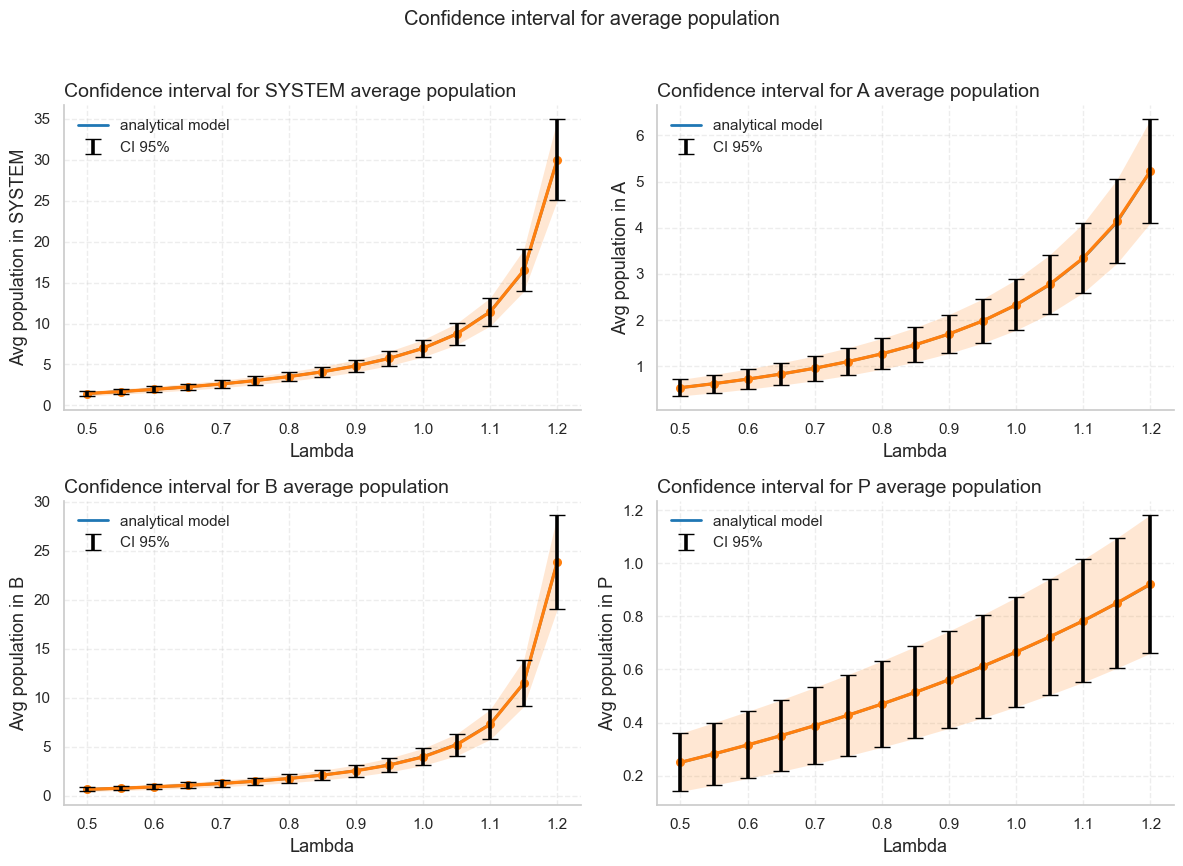

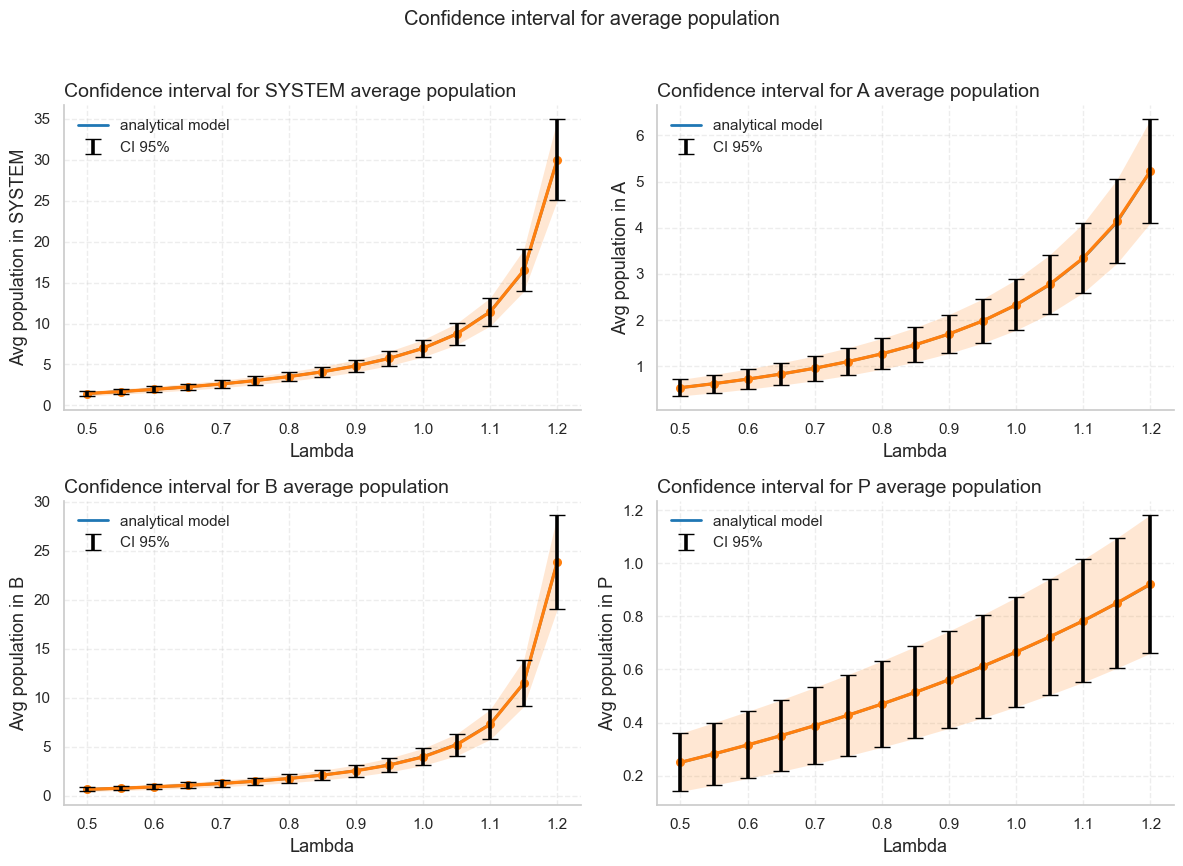

In [45]:
# 1) visite
visits = {"A": 3, "B": 1, "P": 1}

# 2) μ stimati dai CSV (già nel tuo codice)
mu_hat = estimate_mu_from_files(files, visits)

# 3) grafici con banda CI "alla plot_system_rt"
plot_finite_population_dynamic_banded(
    files,
    n_rep=100,
    conf=0.95,
    ci_design_effect=12.0,
    ci_fill=True,
    min_display_half=0.0,          # aumenta p.es. a 0.02 per barre più visibili
    mu_params=mu_hat,
    visits=visits,
    node_order=["A", "B", "P"],
    figsize=(12, 9)
)


In [46]:
def plot_nodes_rt(df_all: pd.DataFrame,
                  *,
                  nodes: tuple[str, ...] | None = None,
                  width: float = 9.5,
                  height: float = 5.2,
                  dpi: int = 130,
                  show_theory: bool = True,
                  zoom_range: tuple[float, float] | None = (0.8, 1.21),
                  x_overview_cap: float = 1.6,
                  right_pad_ratio: float = 0.06,
                  y_cap_overview: float | None = None,
                  y_cap_zoom: float | None = None,
                  percentile_cap: float = 99.0,
                  per_job_nodes: set[str] = set(),      # <— per-visita di default (coerente col CSV)
                  zoom_box_frac: float = 1):         # altezza del box grigio nell’overview (4%)
    """
    NODES: overview = SOLO mean; zoom = mean ± CI.
    Teoria per nodo j:
      - se j in per_job_nodes:   R_j = D_j / (1 - λ D_j)        (tempo totale al nodo per job)
      - altrimenti (default):    R_j = S_j / (1 - λ D_j)        (tempo per-visita) con D_j = V_j S_j
    La teoria è mascherata a destra di X_sat e per valori non fisici.
    """

    # --- dati nodo ---
    df_nodes = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "mean_response_time" not in df_nodes.columns:
        print("Mancano dati NODE_*/mean_response_time.")
        return

    scopes_all = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if nodes is not None:
        wanted = {f"NODE_{n}" for n in nodes}
        scopes = [s for s in scopes_all if s in wanted]
    else:
        scopes = scopes_all
    if not scopes:
        print("Nessun nodo da plottare dopo il filtro.")
        return

    # --- asse X + demands ---
    xcol, xlabel = choose_node_x(df_nodes)
    Ddict = estimate_demands_from_df(df_all)           # deve dare almeno D_* e X_sat
    X_sat = float(Ddict["X_sat"])
    eps   = max(1e-9, 5*np.finfo(float).eps * X_sat)

    # fallback visite se mancanti
    VISITS_DEFAULT = {"A": 3.0, "B": 1.0, "P": 1.0}

    # --- aggregazioni ---
    agg_by_node = {
        scope: agg_ci(df_nodes[df_nodes["scope"] == scope], xcol, "mean_response_time")
        for scope in scopes
    }

    # --- range X overview (come SYSTEM) ---
    x_all = pd.concat([agg_by_node[s][xcol] for s in scopes], ignore_index=True)
    x_min, x_max = float(np.nanmin(x_all)), float(np.nanmax(x_all))
    x_overview_min = x_min if zoom_range is None else min(x_min, zoom_range[0])
    x_target_max = max(x_max, (zoom_range[1] if zoom_range else x_max), X_sat * 1.02)
    x_overview_max = min(x_target_max * (1.0 + right_pad_ratio), x_overview_cap)

    # --- helper plot ---
    def draw_mean(ax, g, *, color, label):
        x = g[xcol].to_numpy()
        m = g["mean"].to_numpy(dtype=float)
        ax.plot(x, m, "o-", linewidth=2.0, color=color, label=label)
        return m
    
    def draw_mean_ci(ax, g, *, color, label):
        x  = g[xcol].to_numpy()
        m  = g["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(g["ci_lo"]), g["ci_lo"], m)
        hi = np.where(np.isfinite(g["ci_hi"]), g["ci_hi"], m)
        ax.errorbar(x, m, yerr=[m - lo, hi - m], fmt="o-", color=color,
                    ecolor=color, elinewidth=2.0, capsize=5, alpha=0.9, linewidth=2.0,
                    label=label)
        return m, lo, hi
    
    def r_theory_node(node_name: str, xgrid: np.ndarray) -> np.ndarray:
        Dj = float(Ddict.get(f"D_{node_name}", np.nan))  # D = V*S
        Vj = float(Ddict.get(f"V_{node_name}", VISITS_DEFAULT.get(node_name, 1.0)))
        Sj_from = Ddict.get(f"S_{node_name}", None)
        if Sj_from is not None and np.isfinite(Sj_from) and Sj_from > 0:
            Sj = float(Sj_from)
        else:
            Sj = Dj / Vj if np.isfinite(Dj) and Dj > 0 and np.isfinite(Vj) and Vj > 0 else np.nan
        if not (np.isfinite(Dj) and Dj > 0 and np.isfinite(Sj) and Sj > 0):
            return np.full_like(xgrid, np.nan, dtype=float)

        y = (Dj if node_name in per_job_nodes else Sj) / (1.0 - xgrid * Dj)
        mask = (xgrid <= X_sat - eps) & np.isfinite(y) & (y > 0)
        return np.where(mask, y, np.nan)

    def auto_cap(pool):
        vals = np.hstack([p[np.isfinite(p)] for p in pool if p is not None] or [])
        if vals.size:
            cap = np.nanpercentile(vals, percentile_cap) * 1.05
            return float(cap) if np.isfinite(cap) else None
        return None

    # --- figure: overview + zoom ---
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(width, height * 1.35), dpi=dpi,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    grid_over = np.linspace(max(1e-6, x_overview_min * 0.98), x_overview_max, 2000)
    grid_z    = np.linspace(zoom_range[0], zoom_range[1], 1200)

    pool_o, pool_z = [], []

    for scope in scopes:
        node  = scope.replace("NODE_", "")
        label = _node_label(scope)
        col   = PALETTE.get(node, "#333333")

        # overview → SOLO mean
        m_o = draw_mean(ax1, agg_by_node[scope], color=col, label=f"{label} (mean)")
        pool_o.append(m_o)

        # zoom → mean ± CI
        m_z, lo_z, hi_z = draw_mean_ci(ax2, agg_by_node[scope], color=col,
                                       label=f"{label} (mean ± CI)")
        pool_z.extend([m_z, lo_z, hi_z])

        # teoria (mascherata)
        if show_theory:
            y_over = r_theory_node(node, grid_over)
            y_zoom = r_theory_node(node, grid_z)
            if np.isfinite(y_over).any():
                ax1.plot(grid_over, y_over, color=col, linestyle="--",
                         linewidth=1.5, alpha=0.9, label=f"{label} theory")
            if np.isfinite(y_zoom).any():
                ax2.plot(grid_z, y_zoom, color=col, linestyle="--",
                         linewidth=1.5, alpha=0.9, label=f"{label} theory")

    # X_sat
    if x_overview_min <= X_sat <= x_overview_max:
        ax1.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label="X_sat")
    if zoom_range[0] <= X_sat <= zoom_range[1]:
        ax2.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9,
                    linewidth=2.0, label="X_sat")

    # cap Y auto (se non forniti)
    if y_cap_overview is None:
        y_cap_overview = auto_cap(pool_o)
    if y_cap_zoom is None:
        y_cap_zoom = auto_cap(pool_z)

    ax1.set_xlim(x_overview_min, x_overview_max)
    ax2.set_xlim(*zoom_range)
    ax1.set_ylim(bottom=0, top=y_cap_overview)
    ax2.set_ylim(bottom=0, top=y_cap_zoom)

    # box grigio “zoom” nell’overview (disegnato DOPO i limiti)
    import matplotlib.patches as patches
    y0, y1 = ax1.get_ylim()
    ax1.add_patch(patches.Rectangle(
        (zoom_range[0], y0),
        zoom_range[1] - zoom_range[0],
        (y1 - y0) * float(zoom_box_frac),
        facecolor="none", edgecolor="gray", linestyle="--", linewidth=2.0, zorder=6
    ))

    # aspetto
    ax1.set_ylabel("Mean Response Time (s)")
    ax2.set_ylabel("Mean Response Time (s)")
    ax1.set_title(f"{TITLE_PREFIX} — NODES: overview + zoom")
    ax2.set_title(f"Zoom su {zoom_range[0]:.3g}–{zoom_range[1]:.3g}")
    ax1.grid(True, linestyle="--", alpha=0.35)
    ax2.grid(True, linestyle="--", alpha=0.35)

    # legende (deduplicate per pulizia)
    for ax in (ax1, ax2):
        h, l = ax.get_legend_handles_labels()
        uniq = dict(zip(l, h))
        ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9)

    plt.tight_layout()
    plt.show()


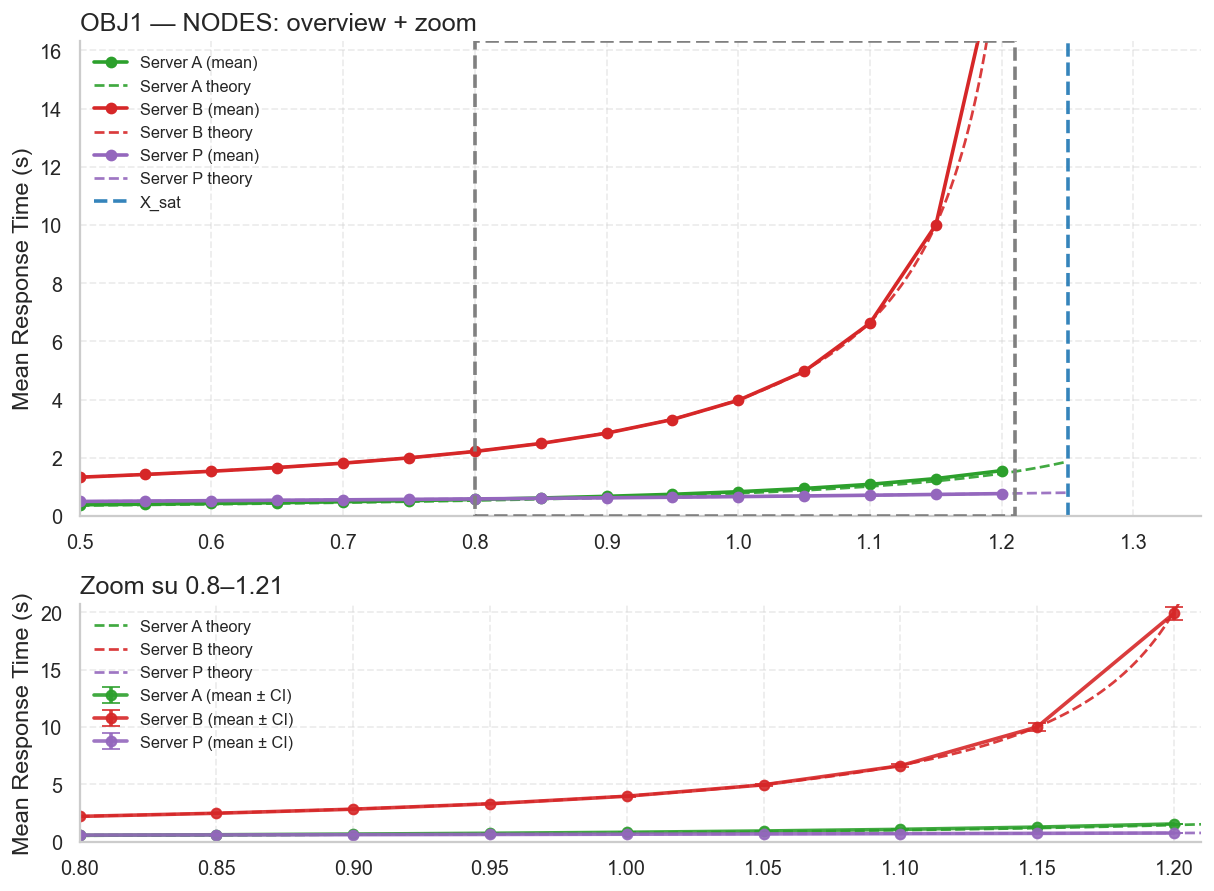

In [47]:
# tutti i nodi rilevati

plot_nodes_rt(df_all, per_job_nodes=set(), zoom_range=(0.8, 1.21)) #usare questo per obj1 e 2
#plot_nodes_rt(df_all, per_job_nodes=set(), zoom_range=(1.21,1.43)) #questo per obj3
# solo un sottoinsieme esplicito (se vuoi)



In [48]:
def plot_system_throughput(df_all: pd.DataFrame,
                           *,
                           width: float = 8.6,
                           height: float = 4.6,
                           dpi: int = 130,
                           show_theory: bool = True,
                           clip_at_Xsat: bool = False,
                           show_residuals: bool = True):
    """
    Confronto throughput complessivo (simulato mean±CI) vs teorico + residui (%).
    Teoria: X(λ) = λ per λ <= X_sat. Se clip_at_Xsat=True, plateau a X_sat oltre.
    """
    # Stime demand + X_sat
    D = estimate_demands_from_df(df_all)
    X_sat = float(D["X_sat"])
    eps = max(1e-9, 5*np.finfo(float).eps * X_sat)

    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "throughput" not in df_overall.columns:
        print("Mancano dati OVERALL/throughput."); 
        return

    # preferisci λ come asse; altrimenti replica
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        xcol, xlabel = "arrival_rate", "Arrival Rate (λ)"
    else:
        xcol, xlabel = ("replica", "Replica")

    agg = agg_ci(df_overall, xcol, "throughput")

    # --- Figure (con o senza pannello residui) ---
    if show_residuals and xcol == "arrival_rate" and show_theory:
        fig, (ax, axr) = plt.subplots(
            2, 1, figsize=(width, height*1.15), dpi=dpi,
            gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        axr = None

    # Simulazione (mean ± CI) con marker dinamici
    x  = agg[xcol].to_numpy()
    mu = agg["mean"].to_numpy(dtype=float)
    lo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"], mu)
    hi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"], mu)

    sim_color = PALETTE.get("SIM", "C0")
    ms = marker_style_for(0, sim_color)
    ax.plot(x, mu, linewidth=2.1, color=sim_color, label="Sim (mean)", **ms)
    ax.fill_between(x, lo, hi, alpha=0.18, linewidth=0, color=sim_color, label="CI 95%")

    # Teoria
    y_theory_at_x = None
    if show_theory and xcol == "arrival_rate":
        xgrid = np.linspace(float(np.nanmin(x))*0.98, float(np.nanmax(x))*1.02, 800)
        X_theory = np.where(xgrid <= X_sat - eps, xgrid, (X_sat if clip_at_Xsat else np.nan))
        ax.plot(xgrid, X_theory, color=PALETTE["THEORY"], linewidth=2.0,
                label=("Teoria (plateau)" if clip_at_Xsat else "Teoria"))

        # teoria campionata sugli stessi punti della simulazione (per residui)
        y_theory_at_x = np.interp(x, xgrid, X_theory)

    # X_sat
    if xcol == "arrival_rate":
        ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0,
                   label=f"X_sat ≈ {X_sat:.3f}")

    ax.set_ylabel("Throughput X (req/s)")
    ax.set_title(f"{TITLE_PREFIX} — SYSTEM: Throughput (sim vs teoria)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda deduplicata
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left")

    # --- Residui (%)
    if axr is not None and y_theory_at_x is not None and np.isfinite(y_theory_at_x).any():
        pct_err = 100.0 * (mu - y_theory_at_x) / np.maximum(y_theory_at_x, 1e-12)
        axr.axhline(0.0, color="#666666", linewidth=1.2)
        axr.plot(x, pct_err, "-", color=sim_color, **ms)
        axr.set_ylabel("% err")
        axr.grid(True, linestyle="--", alpha=0.35)
        axr.set_xlabel(xlabel)
    else:
        ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()




In [49]:
def plot_nodes_throughput(df_all: pd.DataFrame,
                          *,
                          nodes: tuple[str, ...] | None = None,
                          width: float = 9.5,
                          height: float = 5.0,
                          dpi: int = 130,
                          show_theory: bool = True,
                          clip_at_Xsat: bool = True,
                          show_residuals: bool = True):
    """
    Confronto throughput per-nodo (simulato mean±CI) vs teorico + residui (%).
    Teoria: X_j(λ) = V_j * X(λ) con X(λ)=λ per λ<=X_sat (e plateau opzionale).
    Marker dinamici per nodo (supporta 4+ nodi).
    """
    df_nodes = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if df_nodes.empty or "throughput" not in df_nodes.columns:
        print("Mancano dati NODE_*/throughput."); 
        return

    # nodi dinamici/filtro
    scopes_all = _node_order(df_nodes["scope"].dropna().unique().tolist())
    if nodes is not None:
        wanted = {f"NODE_{n}" for n in nodes}
        scopes = [s for s in scopes_all if s in wanted]
    else:
        scopes = scopes_all
    if not scopes:
        print("Nessun nodo da plottare dopo il filtro."); 
        return

    # Asse X
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        xcol, xlabel = "arrival_rate", "Arrival Rate (λ)"
    else:
        xcol, xlabel = ("replica", "Replica")

    # Stime demand + X_sat e visite
    Ddict = estimate_demands_from_df(df_all)
    X_sat = float(Ddict["X_sat"])
    eps   = max(1e-9, 5*np.finfo(float).eps * X_sat)
    VISITS_DEFAULT = {"A": 3.0, "B": 1.0, "P": 1.0}

    # Aggrego simulazione per nodo
    agg_by_node = {scope: agg_ci(df_nodes[df_nodes["scope"] == scope], xcol, "throughput")
                   for scope in scopes}

    # --- Figure (con o senza residui)
    if show_residuals and xcol == "arrival_rate" and show_theory:
        fig, (ax, axr) = plt.subplots(
            2, 1, figsize=(width, height*1.18), dpi=dpi,
            gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )
    else:
        fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
        axr = None

    # Simulazione: una curva per nodo (mean±CI) con marker dinamici
    scope_index = {scope: idx for idx, scope in enumerate(scopes)}
    for scope in scopes:
        node  = scope.replace("NODE_", "")
        label = _node_label(scope)
        col   = PALETTE.get(node, f"C{scope_index[scope] % 10}")
        g = agg_by_node[scope]

        x  = g[xcol].to_numpy()
        mu = g["mean"].to_numpy(dtype=float)
        lo = np.where(np.isfinite(g["ci_lo"]), g["ci_lo"], mu)
        hi = np.where(np.isfinite(g["ci_hi"]), g["ci_hi"], mu)

        ms = marker_style_for(scope_index[scope], col)
        ax.plot(x, mu, linewidth=2.0, color=col, label=f"{label} (sim mean)", **ms)
        ax.fill_between(x, lo, hi, alpha=0.16, linewidth=0, color=col, label=f"{label} CI95%")

    # Teoria per nodo e residui
    if show_theory and xcol == "arrival_rate":
        # griglia comune per la teoria
        x_all = np.unique(np.hstack([agg_by_node[s][xcol].to_numpy() for s in scopes]))
        xgrid = np.linspace(float(np.nanmin(x_all))*0.98, float(np.nanmax(x_all))*1.02, 800)
        X_theory = np.where(xgrid <= X_sat - eps, xgrid, (X_sat if clip_at_Xsat else np.nan))

        for scope in scopes:
            node  = scope.replace("NODE_", "")
            label = _node_label(scope)
            col   = PALETTE.get(node, f"C{scope_index[scope] % 10}")
            Vj = float(Ddict.get(f"V_{node}", VISITS_DEFAULT.get(node, 1.0)))
            yj_grid = Vj * X_theory
            ax.plot(xgrid, yj_grid, linestyle="--", linewidth=1.6, color=col, alpha=0.9,
                    label=f"{label} teoria")

            # residui (%) sugli stessi punti della simulazione
            g = agg_by_node[scope]
            x  = g[xcol].to_numpy()
            mu = g["mean"].to_numpy(dtype=float)
            y_theo_x = Vj * np.interp(x, xgrid, X_theory)
            if axr is not None and np.isfinite(y_theo_x).any():
                ms = marker_style_for(scope_index[scope], col)
                pct_err = 100.0 * (mu - y_theo_x) / np.maximum(y_theo_x, 1e-12)
                axr.plot(x, pct_err, "-", color=col, label=f"{label} %err", **ms)

    # X_sat
    if xcol == "arrival_rate":
        ax.axvline(X_sat, linestyle="--", color=PALETTE["THEORY"], alpha=0.9, linewidth=2.0, label="X_sat")

    ax.set_ylabel("Node Throughput X_j (req/s)")
    ax.set_title(f"{TITLE_PREFIX} — NODES: Throughput (sim vs teoria)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # legenda deduplicata
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left", fontsize=9, ncol=2)

    if axr is not None:
        axr.axhline(0.0, color="#666666", linewidth=1.2)
        axr.set_ylabel("% err")
        axr.grid(True, linestyle="--", alpha=0.35)
        axr.set_xlabel(xlabel)
    else:
        ax.set_xlabel(xlabel)

    plt.tight_layout()
    plt.show()


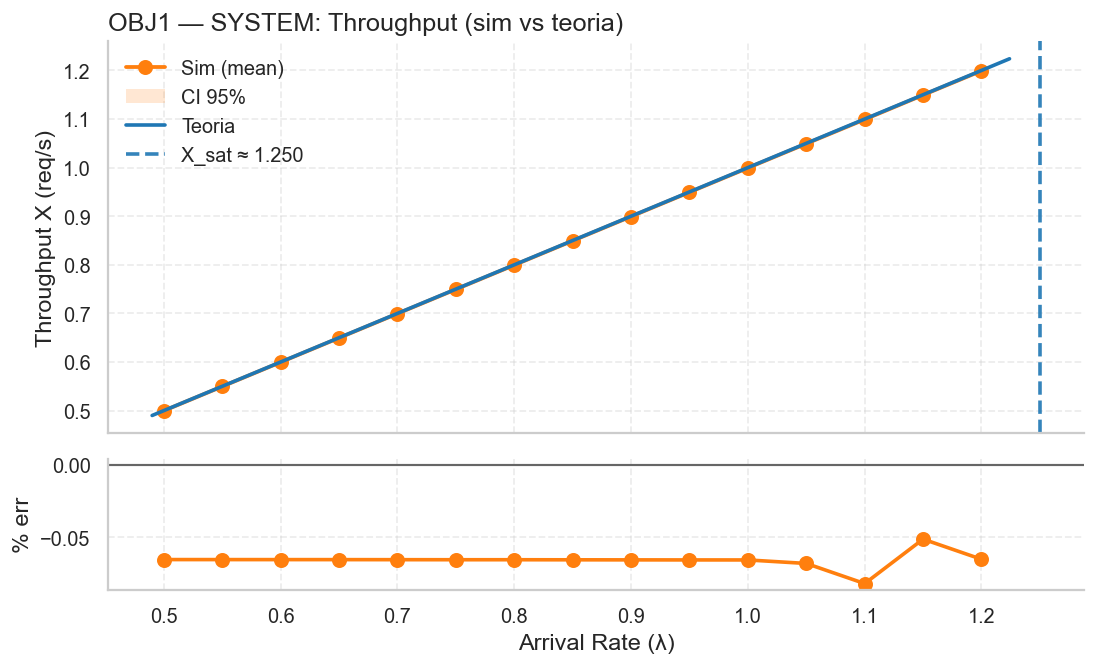

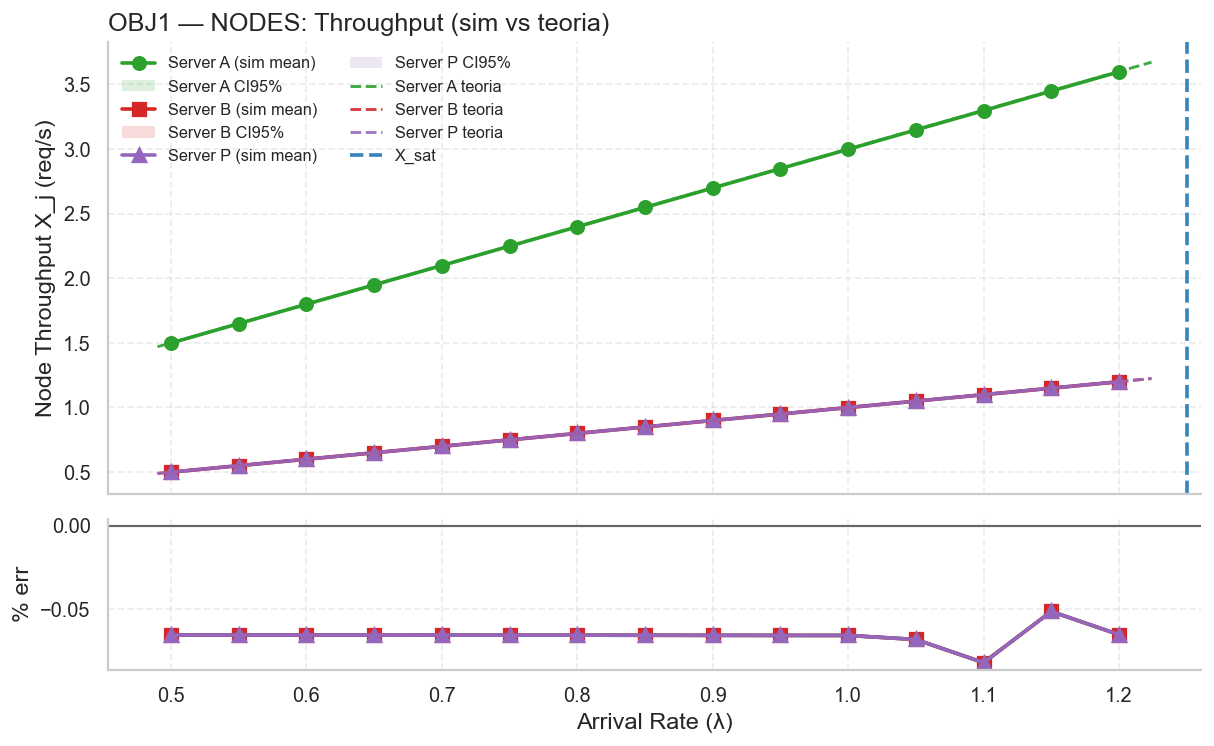

In [50]:
# Confronto throughput complessivo
plot_system_throughput(df_all, clip_at_Xsat=False)

# Confronto throughput per nodo (usa le visite nominali se non hai V_j stimati)
plot_nodes_throughput(df_all, clip_at_Xsat=False)


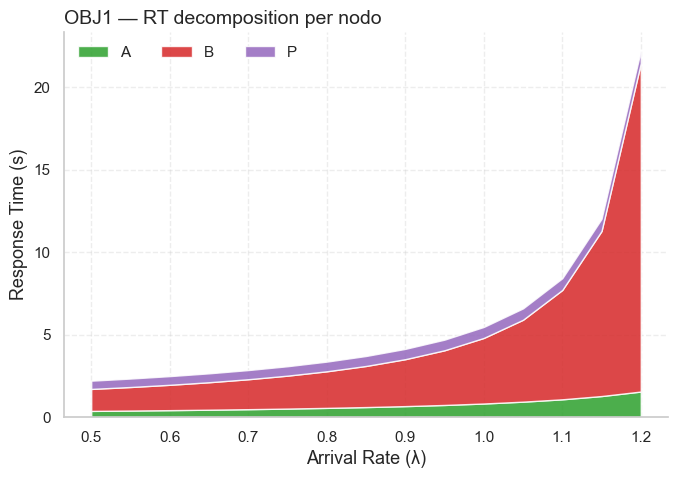

In [51]:
def plot_rt_decomposition(df_all: pd.DataFrame, percent: bool = False):
    """
    Disegna la decomposizione del tempo di risposta per tutti i nodi NODE_* presenti.
    Se percent=True, mostra le percentuali (0–100%) invece dei valori assoluti.
    """
    # filtra righe dei nodi
    dn = df_all[df_all["scope"].astype(str).str.startswith("NODE_")].copy()
    if dn.empty or "mean_response_time" not in dn.columns:
        print("[INFO] Dati insufficienti per RT decomposition.")
        return

    # media per (λ, nodo)
    dn = dn.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)

    # pivot: righe = λ, colonne = NODE_*
    piv = dn.pivot(index="arrival_rate", columns="scope", values="mean_response_time").fillna(0.0)

    # ordina colonne alfabeticamente per nodo (A,B,C,P,...)
    cols = sorted(piv.columns, key=lambda s: s.replace("NODE_", ""))
    piv = piv[cols].sort_index()

    # se percentuale, normalizza per riga
    if percent:
        totals = piv.sum(axis=1).replace(0, np.nan)
        piv = piv.div(totals, axis=0) * 100.0

    # etichette "A","B","C","P",... e colori (se PALETTE è definita)
    labels = [c.replace("NODE_", "") for c in piv.columns]
    colors = []
    for lab in labels:
        try:
            colors.append(PALETTE.get(lab, None))  # usa palette se disponibile
        except NameError:
            colors.append(None)  # fallback: colori default di Matplotlib

    # se nessun colore esplicito, lascia che Matplotlib scelga la palette
    use_colors = None if all(c is None for c in colors) else colors

    fig, ax = plt.subplots(figsize=(7.8, 5.0))
    ax.stackplot(piv.index, *[piv[c].values for c in piv.columns],
                 labels=labels, colors=use_colors, alpha=0.85)
    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Share of Response Time (%)" if percent else "Response Time (s)")
    if percent:
        ax.set_ylim(0, 100)
    ax.set_title(f"{TITLE_PREFIX} — RT decomposition per nodo" + (" (%)" if percent else ""))
    ax.legend(loc="upper left", ncol=min(4, len(labels)))
    ax.grid(True, linestyle="--", alpha=0.35)
    plt.show()
plot_rt_decomposition(df_all)

Sull’asse X hai il tasso di arrivo (λ), cioè quante richieste al secondo entrano nel sistema.

Sull’asse Y hai il tempo medio di risposta complessivo, ma scomposto (empilato) per ciascun nodo.

Le aree colorate mostrano quanto ciascun nodo contribuisce al tempo totale.

Interpretazione della figura:

La parte verde (A) è il tempo medio speso sul server A (front-end). Rimane sempre piccola.

La parte viola (P) è il tempo medio sul provider esterno. È quasi costante e poco rilevante.

La parte rossa (B) è il tempo medio speso sul server B (app + DB). Questa cresce rapidamente con λ e diventa dominante.

In altre parole, la figura ti dice visivamente che:

quando il carico è basso, il tempo totale è distribuito un po’ fra tutti i nodi,

ma già per λ intorno a 0.9–1.0 il server B diventa il collo di bottiglia,

e vicino a λ=1.2 quasi tutto il tempo di risposta è dovuto a B.

È un modo elegante per mostrare chi sta rallentando il sistema: la crescita verticale della parte rossa significa che il collo di bottiglia si concentra lì.

Seeds trovati: [314159265, 673620713, 779946103, 1463093617, 1899032171]


C:\Users\leopo\AppData\Local\Temp\ipykernel_10512\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = df.replace({"-": np.nan}).copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_10512\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out = df.replace({"-": np.nan}).copy()
C:\Users\leopo\AppData\Local\Temp\ipykernel_10512\1158184731.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_

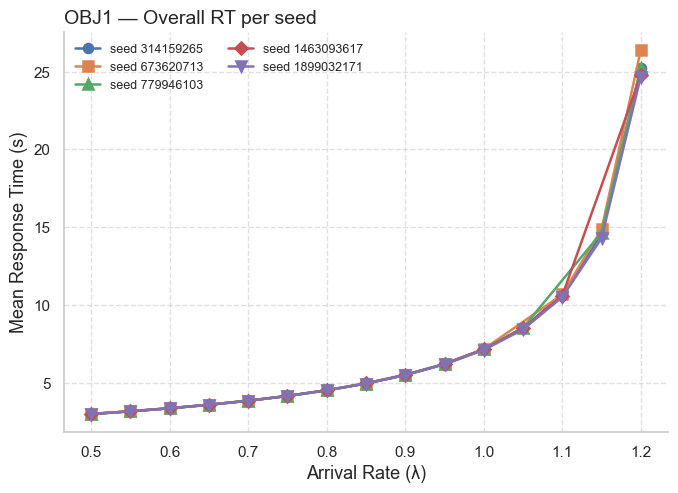

In [52]:

# --- pattern dinamici in base a OBJ e BASE_DIR ---
def make_patterns(obj: int, base_dir: str) -> list[str]:
    """
    Genera una lista di pattern possibili per i CSV per-seed.
    Tenta varianti con/senza 'arrivals' e diverse separazioni per safety.
    """
    base_dir = base_dir.rstrip("/\\")
    patterns = [
        os.path.join(base_dir, f"results_obj{obj}_arrivals_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_run*_seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_arrivals_*seed*.csv"),
        os.path.join(base_dir, f"results_obj{obj}_*seed*.csv"),
    ]
    return patterns

# regex seed più permissivo: _seed42, -seed=42, _seed-42, ecc.
_SEED_RE = re.compile(r"[ _-]seed[=_-]?(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def load_arrivals_by_seed(patterns: Iterable[str]) -> pd.DataFrame:
    """
    Carica tutti i CSV che matchano uno QUALSIASI dei pattern,
    aggiunge colonne source/replica/seed. Se non trova nulla, stampa i pattern provati.
    """
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(set(files))  # dedup
    if not files:
        print("[WARN] Nessun CSV trovato per i pattern seguenti:")
        for p in patterns:
            print(" -", p)
        # opzionale: lista rapida della cartella
        base_dirs = sorted(set(os.path.dirname(p) for p in patterns))
        for d in base_dirs:
            try:
                print(f"\nContenuto di {d}:")
                for name in sorted(os.listdir(d)):
                    if name.endswith(".csv"):
                        print("   ", name)
            except FileNotFoundError:
                print(f"(Cartella inesistente: {d})")
        raise FileNotFoundError("Nessun CSV per-seed trovato.")
    dfs = []
    for i, f in enumerate(files):
        df = pd.read_csv(f)
        df = _coerce_numeric(df)  # numerico ovunque possibile
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        df["seed"]    = _seed_from_name(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def per_seed_overall(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF OVERALL (una riga per λ, media se più righe)}"""
    df_ov = df_all[df_all["scope"] == "OVERALL"].copy()
    out = {}
    for seed, g in df_ov.groupby("seed"):
        gg = g.groupby("arrival_rate", as_index=False).mean(numeric_only=True)
        gg = gg.sort_values("arrival_rate").reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

def per_seed_nodes(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF nodi} una riga per (λ, scope)"""
    dn = df_all.copy()
    dn["scope"] = dn["scope"].astype(str)  # safety contro NaN
    dn = dn[dn["scope"].str.startswith("NODE_")]
    out = {}
    for seed, g in dn.groupby("seed"):
        gg = g.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)
        gg = gg.sort_values(["arrival_rate", "scope"]).reset_index(drop=True)
        out[int(seed) if pd.notna(seed) else -1] = gg
    return out

# ----------------------------- plotting --------------------------------

from typing import Iterable, Dict
import matplotlib.pyplot as plt

def plot_overall_rt_per_seed(seed_to_df: Dict[int, pd.DataFrame],
                             title=None, ylabel="Mean Response Time (s)"):
    """Curve OVERALL per ogni seed, con marker dinamici e colori consistenti."""
    fig, ax = plt.subplots(figsize=(7.8, 5.2))

    for i, (seed, df) in enumerate(sorted(seed_to_df.items())):
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            color = f"C{i % 10}"                     # colori dal ciclo default di Matplotlib
            ms = marker_style_for(i, color)          # <-- marker dinamico
            ax.plot(df["arrival_rate"], df["mean_response_time"],
                    color=color, linewidth=1.8, label=f"seed {seed}", **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel(ylabel)
    ax.set_title(title or f"{TITLE_PREFIX} — Overall RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(ncol=2, fontsize=9)
    plt.show()


def plot_node_rt_per_seed(seed_to_nodes: Dict[int, pd.DataFrame], title=None):
    """
    Curve per nodo (A/B/P/...) per ciascun seed, con marker dinamici:
    - stessa forma/riempimento per lo *stesso nodo* in tutti i seed;
    - colori: PALETTE per i nodi noti, fallback alla palette di Matplotlib.
    """
    # ordine stabile dei NODE_* presente in tutti i DF
    all_scopes = []
    for df in seed_to_nodes.values():
        if "scope" in df.columns:
            all_scopes.extend(df["scope"].dropna().astype(str).unique().tolist())
    scopes_sorted = sorted({s for s in all_scopes if s.startswith("NODE_")})
    scope_index  = {scope: idx for idx, scope in enumerate(scopes_sorted)}

    fig, ax = plt.subplots(figsize=(8.6, 5.2))

    for seed, df in sorted(seed_to_nodes.items()):
        for scope, g in df.groupby("scope"):
            if not {"arrival_rate", "mean_response_time"}.issubset(g.columns):
                continue
            node = scope.replace("NODE_", "")
            idx  = scope_index.get(scope, 0)
            color = PALETTE.get(node, f"C{idx % 10}")   # colore coerente per nodo
            ms = marker_style_for(idx, color)           # <-- marker dinamico per nodo
            label = f"{node} — seed {seed}"
            ax.plot(g["arrival_rate"], g["mean_response_time"],
                    color=color, linewidth=1.6, label=label, **ms)

    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Per-node RT per seed")
    ax.grid(True, linestyle="--", alpha=0.6)

    # legenda deduplicata (quando ci sono molte linee)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), ncol=2, fontsize=8)

    plt.show()

def plot_overall_rt_mean_ci_across_seeds(seed_to_df: Dict[int, pd.DataFrame], title=None):
    """Media cross-seed con CI95% riusando line_with_ci."""
    frames = []
    for seed, df in seed_to_df.items():
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            frames.append(df[["arrival_rate", "mean_response_time"]])
    if not frames:
        print("[INFO] Nessun dato OVERALL per costruire la media cross-seed.")
        return
    big = pd.concat(frames, ignore_index=True)
    line_with_ci(
        big, x="arrival_rate", y="mean_response_time",
        title=title or f"{TITLE_PREFIX} — Overall RT (mean ± CI95%) across seeds",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

# --------- ESEMPIO DI USO ---------
patterns = make_patterns(OBJ, BASE_DIR)
df_all = load_arrivals_by_seed(patterns)
print("Seeds trovati:", sorted(df_all["seed"].dropna().unique().astype(int).tolist()))

by_seed_overall = per_seed_overall(df_all)
plot_overall_rt_per_seed(by_seed_overall)

by_seed_nodes = per_seed_nodes(df_all)
# plot_node_rt_per_seed(by_seed_nodes)  # scommenta se vuoi anche per nodo



File conv:
 - .output_simulation\conv_obj1_arrivals_run000_seed314159265_20250827_103122.csv
 - .output_simulation\conv_obj1_arrivals_run015_seed1899032171_20250827_103216.csv
 - .output_simulation\conv_obj1_arrivals_run030_seed1463093617_20250827_103312.csv
 - .output_simulation\conv_obj1_arrivals_run045_seed779946103_20250827_103409.csv
 - .output_simulation\conv_obj1_arrivals_run060_seed673620713_20250827_103506.csv
Seeds trovati: [314159265, 673620713, 779946103, 1463093617, 1899032171]


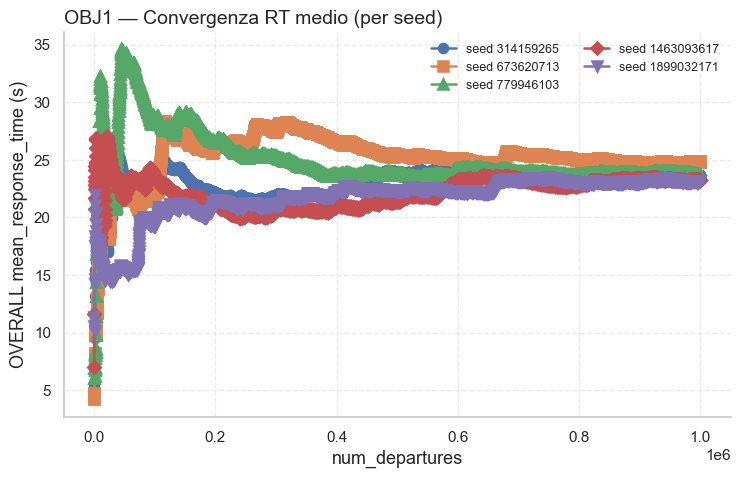

In [53]:
def _lambda_col(df: pd.DataFrame) -> str | None:
    """Trova la colonna dell'arrival rate (robusto a maiuscole/alias)."""
    low = {c.lower().strip(): c for c in df.columns}
    for k in ("arrival_rate", "lambda", "lam"):
        if k in low:
            return low[k]
    return None


# --- loader: lista di DF (uno per file), con seed e source ---
def load_conv_as_list(files: List[str]) -> List[pd.DataFrame]:
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # numeric coercion, ma NON toccare scope/metric
        df = _coerce_numeric(df, exclude=("scope", "metric"))
        df["seed"] = _seed_from_name(f)
        df["source"] = os.path.basename(f)
        dfs.append(df)
    return dfs  # <- LISTA di DataFrame (uno per file)

# --- estrai OVERALL/mean_response_time per seed (dict seed -> DF ordinato per num_departures) ---
def overall_mean_rt_by_seed(dfs: List[pd.DataFrame],
                            arrival_rate: float | None = None,
                            atol: float = 1e-9) -> Dict[int, pd.DataFrame]:
    """
    Ritorna {seed -> DF[num_departures, mean_response_time]}.
    Se arrival_rate è dato, tiene solo le righe con quel λ (tolleranza 'atol').
    """
    out: Dict[int, pd.DataFrame] = {}
    for df in dfs:
        d = df.copy()

        # filtro per λ se richiesto
        lam_col = _lambda_col(d)
        if arrival_rate is not None and lam_col is not None:
            d[lam_col] = pd.to_numeric(d[lam_col], errors="coerce")
            keep = np.isclose(d[lam_col].to_numpy(float), float(arrival_rate),
                              rtol=0.0, atol=atol)
            d = d[keep]

        seed = int(d["seed"].iloc[0]) if "seed" in d.columns and not d.empty else -1
        g = d[(d["scope"] == "OVERALL") & (d["metric"] == "mean_response_time")].copy()
        if g.empty:
            continue
        g = g.sort_values("num_departures")
        out[seed] = g[["num_departures", "value"]].rename(
            columns={"value": "mean_response_time"}
        )

    return out


# --- plot: tutte le curve su un grafico (opzione smoothing con media mobile) ---
def plot_overall_conv_by_seed(seed_to_df: Dict[int, pd.DataFrame],
                              title=None,
                              window_ma: int | None = None,
                              marker_size: float = 0.2,
                              mark_every: int | None = 2000,
                              markers: bool = True,
                              linewidth: float = 0.2):
    fig, ax = plt.subplots(figsize=(8.6, 5.0))
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        color = f"C{i % 10}"
        ms = marker_style_for(i, color)  # hai già definito marker_style_for
        x = g["num_departures"].to_numpy()
        y = g["mean_response_time"].to_numpy(dtype=float)
        if window_ma and window_ma > 1:
            y = pd.Series(y).rolling(window_ma, min_periods=1).mean().to_numpy()
        ax.plot(x, y, linewidth=1.8, color=color, label=f"seed {seed}", **ms)
    ax.set_xlabel("num_departures")
    ax.set_ylabel("OVERALL mean_response_time (s)")
    ax.set_title(title or f"{TITLE_PREFIX} — Convergenza RT medio (per seed)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(ncol=2, fontsize=9)
    plt.show()

# --- plot: una figura per seed (comodo se vuoi guardarli separati) ---
def plot_overall_conv_one_per_seed(seed_to_df: Dict[int, pd.DataFrame], window_ma: int | None = None):
    for i, (seed, g) in enumerate(sorted(seed_to_df.items())):
        plot_overall_conv_by_seed({seed:g},
                                  title=f"{TITLE_PREFIX} — OVERALL mean RT (seed {seed})",
                                  window_ma=window_ma)

# ====== USO ======

# 1) prendi i file conv (usa la tua utility già esistente)
conv_files = find_csv_for_config(config_file, target="conv")
print("File conv:", *conv_files, sep="\n - ")

# 2) lista di DataFrame, uno per file
dfs_conv = load_conv_as_list(conv_files)   # <<< LISTA richiesta

# 3) dict {seed -> DF OVERALL mean RT vs num_departures}
by_seed = overall_mean_rt_by_seed(dfs_conv, arrival_rate=1.2)



print("Seeds trovati:", sorted(by_seed.keys()))

# 4a) grafico unico con tutte le curve (metti window_ma=5000 se vuoi smoothing visivo)
plot_overall_conv_by_seed(by_seed, window_ma=None)

# 4b) (opzionale) un grafico per seed
# plot_overall_conv_one_per_seed(by_seed, window_ma=10000)


In [54]:

def _pretty_scope(s: str) -> str:
    s = str(s)
    if s == "OVERALL":
        return "OVERALL"
    if s.startswith("NODE_"):
        return f"Server {s.replace('NODE_', '')}"
    return s

def _scope_order(scopes):
    scopes = [str(s) for s in scopes]
    over = ["OVERALL"] if "OVERALL" in scopes else []
    nodes = sorted([s for s in scopes if s != "OVERALL"],
                   key=lambda x: (not x.startswith("NODE_"), x))
    return over + nodes

def _normalize_scopes(names):
    """Permette di passare 'A' o 'NODE_A' indistintamente."""
    out = []
    for n in names:
        s = str(n)
        if s == "OVERALL":
            out.append("OVERALL")
        elif s.startswith("NODE_"):
            out.append(s)
        else:
            out.append(f"NODE_{s}")
    return out



def plot_metric_vertical_by_scope(
    df: pd.DataFrame,
    metric: str,
    *,
    scopes: list[str] | None = None,    # se None: tutti
    hue: str | None = "seed",
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    xmax: float | None = None,
    xlimit_scopes: list[str] | None = None,
    arrival_rate: float | list[float] | tuple[float, ...] | None = None,  # << NEW
    atol: float = 1e-9,                                                    # << NEW
):
    """
    Subplot verticale (una riga per scope) della metrica scelta.
    Se 'arrival_rate' è impostato, filtra i dati su quel λ (o su una lista di λ).
    """
    d = df.copy()

    # --- filtro λ, se richiesto ---
    lam_col = _lambda_col(d)
    if arrival_rate is not None and lam_col is not None:
        d[lam_col] = pd.to_numeric(d[lam_col], errors="coerce")
        lam = d[lam_col].to_numpy(float)
        if np.isscalar(arrival_rate):
            keep = np.isclose(lam, float(arrival_rate), rtol=0.0, atol=atol)
        else:
            arr = np.asarray(list(arrival_rate), dtype=float)
            keep = np.any(np.isclose(lam[:, None], arr[None, :], rtol=0.0, atol=atol), axis=1)
        d = d[keep]

    # --- filtro metrica ---
    d = d[d["metric"] == metric].copy()
    if d.empty:
        print(f"[WARN] nessun dato per metric='{metric}' (dopo eventuale filtro λ).")
        return

    # --- filtro scope ---
    all_scopes = d["scope"].dropna().unique().tolist()
    row_order = _scope_order(all_scopes) if scopes is None else _scope_order(scopes)
    d = d[d["scope"].isin(row_order)]
    if d.empty:
        print("[WARN] nessun dato dopo il filtro scope.")
        return

    # --- limite X coerente tra subplot ---
    if xmax is None:
        if xlimit_scopes:
            ref_scopes = set(_normalize_scopes(xlimit_scopes))
        else:
            nonA = [s for s in row_order if s != "NODE_A"]
            ref_scopes = set(nonA) if ("NODE_A" in row_order and nonA) else set(row_order)
        xmax = float(d[d["scope"].isin(ref_scopes)]["num_departures"].max())
    xmin = float(d["num_departures"].min())

    # --- plot ---
    sns.set_theme(style="whitegrid", context="notebook")
    use_hue = hue if (hue is not None and hue in d.columns) else None

    g = sns.relplot(
        data=d, kind="line",
        x="num_departures", y="value",
        row="scope", row_order=row_order,
        hue=use_hue, palette=palette,
        markers=markers, dashes=False,
        linewidth=linewidth, alpha=alpha,
        facet_kws=dict(sharex=True, sharey=False, margin_titles=False),
        height=height, aspect=aspect,
        estimator=None, errorbar=None, sort=True,
    )

    for ax, scope in zip(g.axes.flat, row_order):
        ax.set_title(_pretty_scope(scope))
        ax.set_xlabel("num_departures")
        ax.set_ylabel(metric)
        ax.set_xlim(xmin, xmax)
        ax.grid(True, linestyle="--", alpha=0.35)

    add = ""
    if arrival_rate is not None:
        add = f" — λ={arrival_rate}" if np.isscalar(arrival_rate) else f" — λ∈{list(arrival_rate)}"
    g.figure.suptitle(f"{TITLE_PREFIX} — Convergenza per scope — metrica: {metric}{add}",
                      y=1.02, fontsize=14, weight="bold")

    if use_hue is not None and g._legend is not None:
        g._legend.set_title(use_hue)

    plt.tight_layout()
    plt.show()



In [55]:


def _stack_conv_frames(frames: list[pd.DataFrame],
                       seeds: list[int] | None = None) -> pd.DataFrame:
    # includo anche la colonna di λ se esiste
    lam_name = None
    for df in frames:
        if lam_name is None:
            lam_name = _lambda_col(df)

    kept_cols = ["scope", "metric", "value", "num_departures", "seed", "source"]
    if lam_name and lam_name not in kept_cols:
        kept_cols.append(lam_name)

    buf = []
    for i, df in enumerate(frames):
        d = df.copy()
        d = _coerce_numeric(d, exclude=("scope", "metric"))
        if "seed" not in d.columns or d["seed"].isna().all():
            cand = None
            if "source" in d.columns and isinstance(d["source"].iloc[0], str):
                cand = _seed_from_name(d["source"].iloc[0])
            d["seed"] = cand if cand is not None else i
        d = d[[c for c in kept_cols if c in d.columns]]
        buf.append(d)

    big = pd.concat(buf, ignore_index=True)
    if seeds is not None:
        big = big[big["seed"].isin(seeds)]
    return big

def plot_metric_vertical_by_scope_from_list(
    dfs: List[pd.DataFrame],
    metric: str,
    *,
    scopes: list[str] | None = None,
    seeds: list[int] | None = None,
    hue: str | None = "seed",
    height: float = 2.4,
    aspect: float = 3.2,
    markers: bool = True,
    linewidth: float = 1.2,
    alpha: float = 0.95,
    palette: str | list | None = "tab10",
    xmax: float | None = None,
    xlimit_scopes: list[str] | None = None,
    arrival_rate: float | list[float] | tuple[float, ...] | None = None,  # << NEW
    atol: float = 1e-9,                                                    # << NEW
):
    """Versione che accetta una LISTA di DF (uno per seed/file)."""
    d = _stack_conv_frames(dfs, seeds=seeds)
    return plot_metric_vertical_by_scope(
        d, metric,
        scopes=scopes,
        hue=hue,
        height=height,
        aspect=aspect,
        markers=markers,
        linewidth=linewidth,
        alpha=alpha,
        palette=palette,
        xmax=xmax,
        xlimit_scopes=xlimit_scopes,
        arrival_rate=arrival_rate,   # pass-through
        atol=atol,
    )



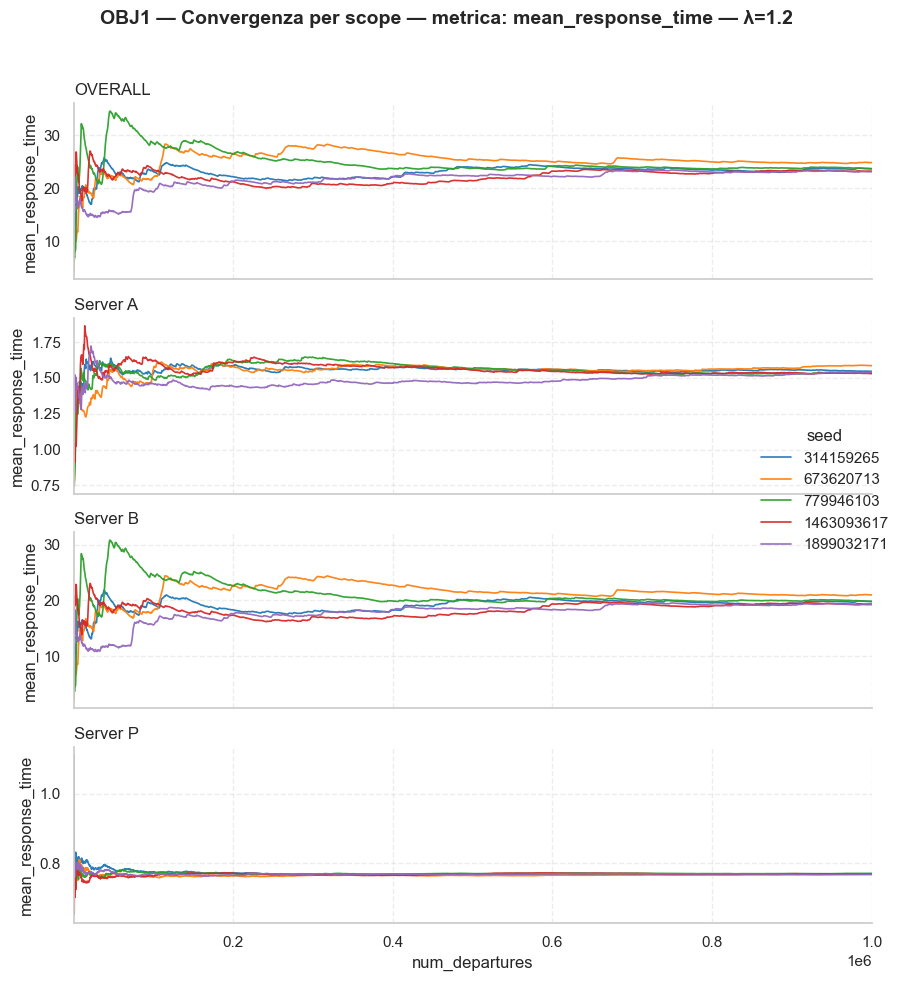

In [56]:


# 2) li carico come LISTA di DF (uno per file/seed)
dfs_conv = load_conv_as_list(conv_files)
"""
plot_metric_vertical_by_scope_from_list(
    dfs_conv, "mean_response_time",
    xlimit_scopes=["OVERALL", "B", "P"]   # 'B' == 'NODE_B', normalizzato
)
"""


# 1) λ singolo
plot_metric_vertical_by_scope_from_list(
    dfs_conv, "mean_response_time",
    arrival_rate=1.2,
    xlimit_scopes=["OVERALL","B","P"]
)


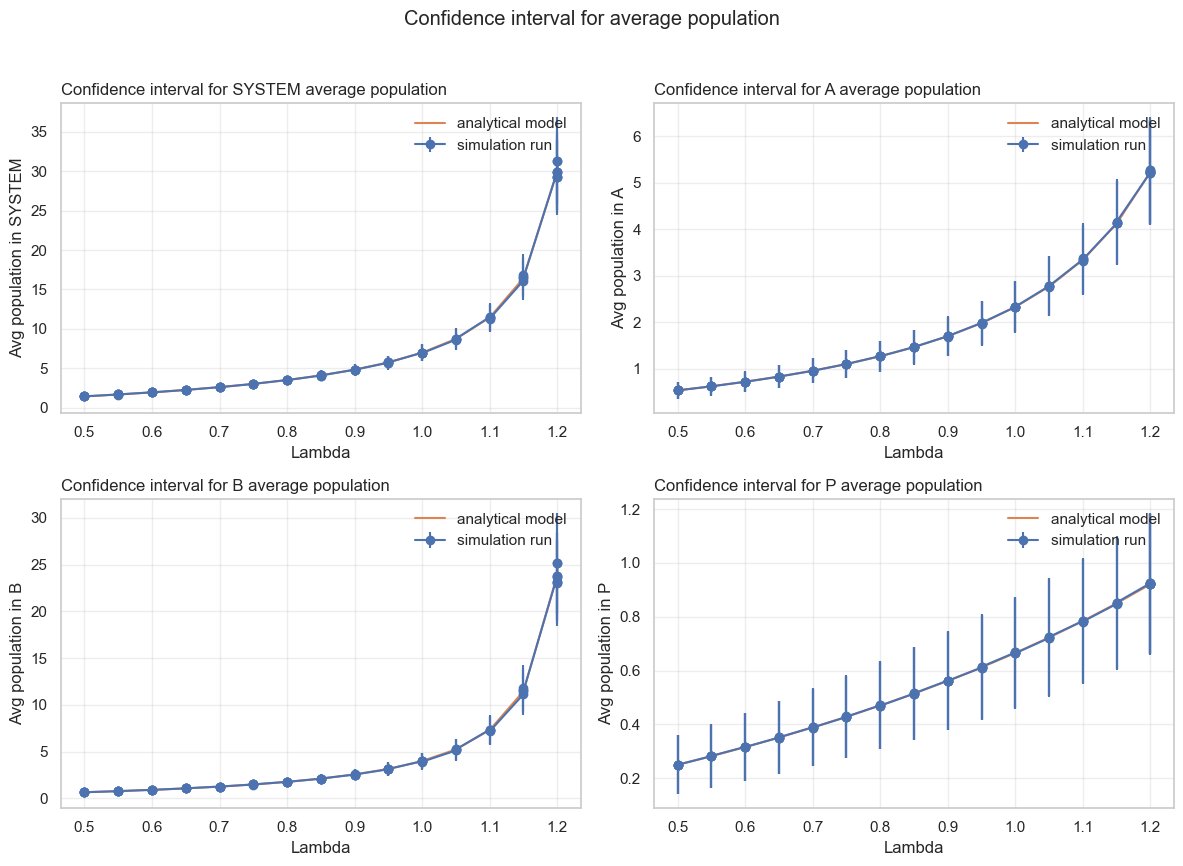

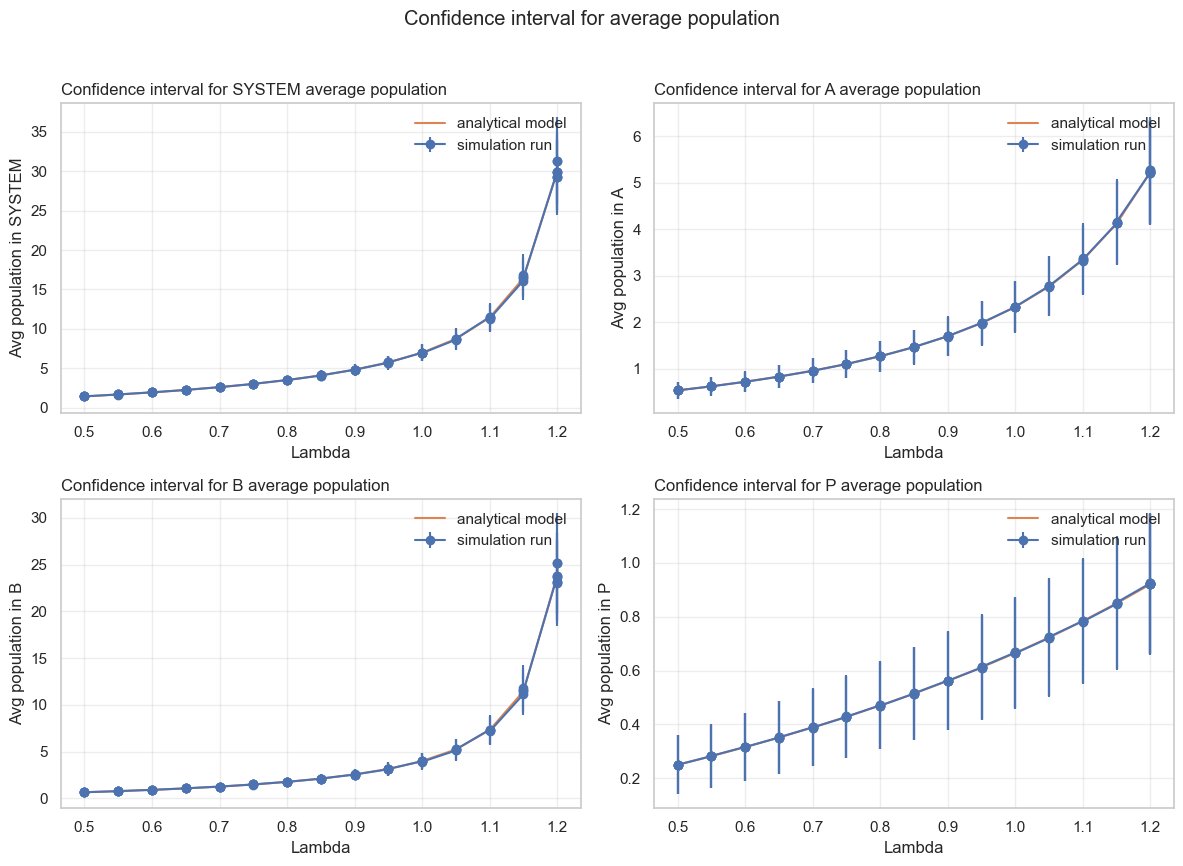

In [57]:
# 1) definisci le visite (quante volte ogni job visita il nodo)
visits = {"A": 3, "B": 1, "P": 1}          # esempio senza C
# visits = {"A": 3, "B": 1, "C": 1, "P": 1} # esempio con C

# 2) stima μ dai CSV (usa 'utilization' a basso carico)
mu_hat = estimate_mu_from_files(files, visits)  # files: DF, path o lista di DF/path

# 3) plottaggio con overlay teorico
plot_finite_population_dynamic(files, n_rep=100, mu_params=mu_hat, visits=visits,
                               node_order=["A","B","P"])   # aggiungi "C" se presente


Stimo D_i dai CSV come median_lambda(U_i/λ).
  D_NODE_A = 0.699724 s/richiesta
  D_NODE_B = 0.799520 s/richiesta
  D_NODE_P = 0.399878 s/richiesta


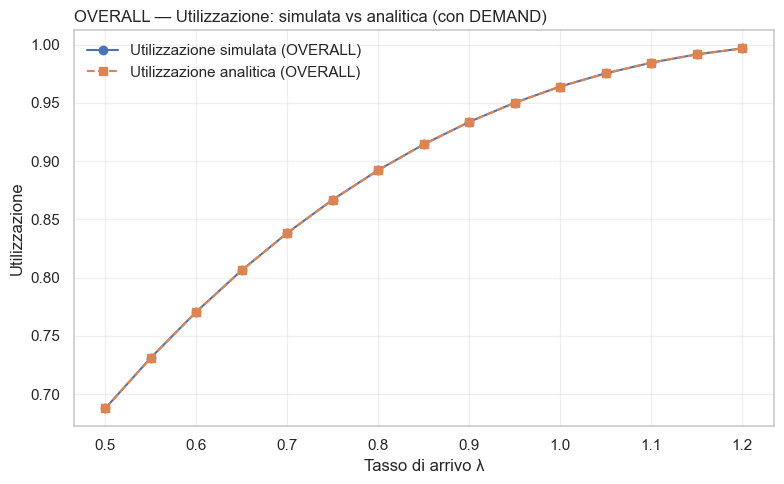

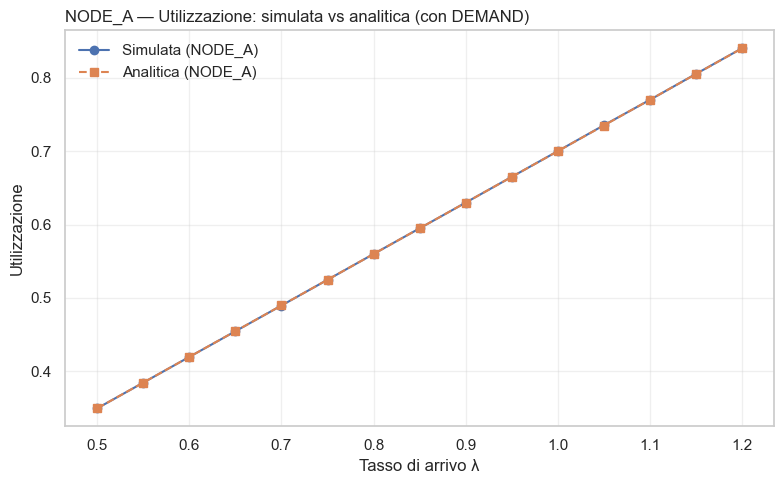

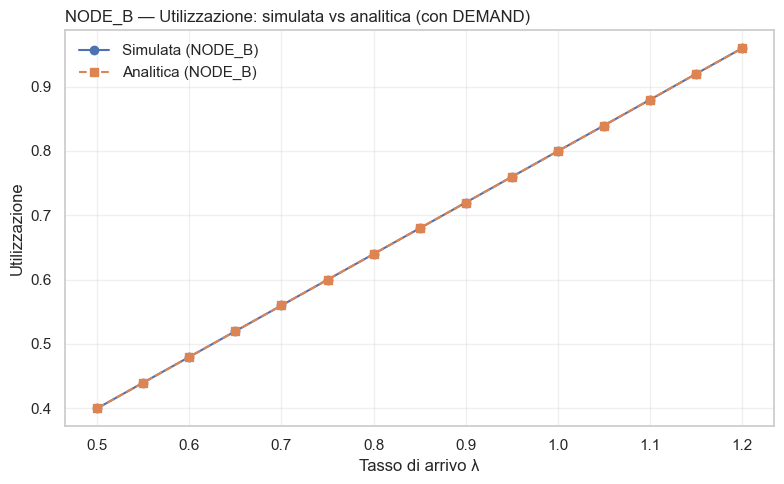

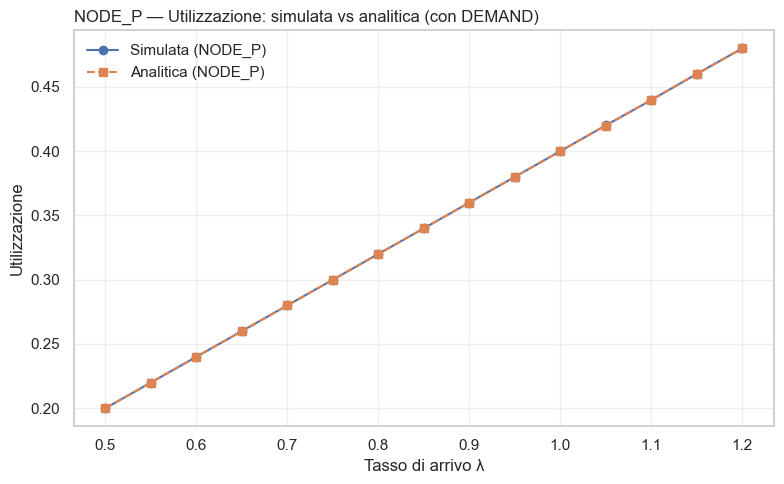

In [58]:
# ===========================================
# Utilizzazione (simulata vs analitica con DEMAND)
# Richiede: df_all già caricato (load_runs(files))
# Usa opzionalmente: SERVICE_DEMANDS/DEMANDS, VISIT_RATIOS
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Prepara i dati aggregati
# ----------------------------
if "df_all" not in globals():
    raise RuntimeError("df_all deve essere già definito (usa le tue find_csv_for_config/load_runs).")

dfu = df_all.copy()
dfu["scope"] = dfu["scope"].astype(str).str.strip().str.upper()

# Media per (scope, λ) in caso di repliche multiple
agg = (
    dfu.groupby(["scope", "arrival_rate"], as_index=False)
       .agg({"utilization": "mean", "throughput": "mean"})
)

# Ricava i nodi (tutto ciò che non è OVERALL)
nodes = sorted([s for s in agg["scope"].unique() if s != "OVERALL"])
if not nodes:
    nodes = ["NODE_A", "NODE_B", "NODE_P"]  # fallback

# ------------------------------------------------------
# 2) Recupero / stima delle DEMAND per richiesta D_i
#    (secondi per richiesta sul nodo i)
# ------------------------------------------------------
D_req = None  # demand per richiesta (non per visita)

# Prova a leggere dizionari definiti nel notebook
D_user = None
try:
    D_user = SERVICE_DEMANDS  # noqa: F821
except NameError:
    pass
if D_user is None:
    try:
        D_user = DEMANDS  # noqa: F821
    except NameError:
        pass

if D_user is not None:
    # Se esistono visit ratio, assumo che D_user siano per visita (S_i) e converto a per richiesta
    V = None
    try:
        V = VISIT_RATIOS  # noqa: F821
    except NameError:
        pass
    if V is not None:
        # D_i (per richiesta) = v_i * S_i
        D_req = {n: float(V[n]) * float(D_user[n]) for n in nodes}
        source_msg = "Uso SERVICE_DEMANDS/DEMANDS come tempi per visita (S_i) + VISIT_RATIOS ⇒ D_i = v_i·S_i."
    else:
        # Non ho i visit ratio ⇒ considero D_user già per richiesta
        D_req = {n: float(D_user[n]) for n in nodes}
        source_msg = "Uso SERVICE_DEMANDS/DEMANDS come demand per richiesta (D_i)."
else:
    # Nessuna demand definita ⇒ stimo dai CSV: D_i ≈ median_lambda( U_i / λ )
    D_req = {}
    for n in nodes:
        g = agg[agg["scope"] == n].copy()
        g = g[g["arrival_rate"] > 0]
        if g.empty:
            raise RuntimeError(f"Nessun dato per stimare la demand su {n}.")
        D_req[n] = float((g["utilization"] / g["arrival_rate"]).median())
    source_msg = "Stimo D_i dai CSV come median_lambda(U_i/λ)."

print(source_msg)
for n in nodes:
    print(f"  D_{n} = {D_req[n]:.6f} s/richiesta")

# (Facoltativo) stima anche S_i e v_i dai CSV per controllo coerenza
V_hat = {}
S_hat = {}
for n in nodes:
    g = agg[agg["scope"] == n].copy()
    g = g[(g["arrival_rate"] > 0) & (g["throughput"] > 0)]
    V_hat[n] = float((g["throughput"] / g["arrival_rate"]).median())  # visite per richiesta
    S_hat[n] = float((g["utilization"] / g["throughput"]).median())   # secondi per visita
# Verifica: V_hat[n]*S_hat[n] ~ D_req[n] (se D_req stimata dai dati)
# print({n: (V_hat[n]*S_hat[n], D_req[n]) for n in nodes})

# ----------------------------------------------------
# 3) Curva analitica per i nodi: ρ_i^th(λ) = λ · D_i
# ----------------------------------------------------
util_theory_nodes = []
for n in nodes:
    g = agg[agg["scope"] == n].copy().sort_values("arrival_rate")
    lam = g["arrival_rate"].to_numpy()
    rho_th = (lam * D_req[n]).clip(0.0, 0.999)  # clip per stabilità grafica
    g["util_theory"] = rho_th
    util_theory_nodes.append(g[["scope", "arrival_rate", "utilization", "util_theory"]])

util_theory_nodes = pd.concat(util_theory_nodes, ignore_index=True)

# -------------------------------------------------------------
# 4) Utilizzazione OVERALL analitica: 1 - Π_i (1 - ρ_i^th(λ))
# -------------------------------------------------------------
wide_th = (
    util_theory_nodes
    .pivot(index="arrival_rate", columns="scope", values="util_theory")
    .dropna(subset=nodes)
    .sort_index()
)
overall_util_th = 1.0 - np.prod(1.0 - wide_th[nodes], axis=1)

# Utilizzazione OVERALL simulata dai CSV
overall_sim = (
    agg[agg["scope"] == "OVERALL"]
    .set_index("arrival_rate")
    .sort_index()
)["utilization"]

# Allineo λ comuni
lam_common = overall_sim.index.intersection(overall_util_th.index)
overall_sim = overall_sim.loc[lam_common]
overall_util_th = overall_util_th.loc[lam_common]

# -----------------------------
# 5) Grafico OVERALL (sim vs th)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(lam_common, overall_sim.values, marker="o", label="Utilizzazione simulata (OVERALL)")
plt.plot(lam_common, overall_util_th.values, marker="s", linestyle="--", label="Utilizzazione analitica (OVERALL)")
plt.xlabel("Tasso di arrivo λ")
plt.ylabel("Utilizzazione")
plt.title("OVERALL — Utilizzazione: simulata vs analitica (con DEMAND)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------
# 6) Grafici per ciascun nodo (sim/th)
# -----------------------------------
for n in nodes:
    g = util_theory_nodes[util_theory_nodes["scope"] == n].copy().sort_values("arrival_rate")
    plt.figure(figsize=(8, 5))
    plt.plot(g["arrival_rate"], g["utilization"], marker="o", label=f"Simulata ({n})")
    plt.plot(g["arrival_rate"], g["util_theory"], marker="s", linestyle="--", label=f"Analitica ({n})")
    plt.xlabel("Tasso di arrivo λ")
    plt.ylabel("Utilizzazione")
    plt.title(f"{n} — Utilizzazione: simulata vs analitica (con DEMAND)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [59]:
# ============================================================
# UTILIZZAZIONE — banda CI stile plot_system_rt + teoria (DOMANDE)
# Requisiti: df_all già caricato (load_runs(files))
# Opzionali: SERVICE_DEMANDS/DEMANDS e VISIT_RATIOS
#            (se assenti, stimo D_i dai CSV: D_i ≈ median_lambda(U_i/λ))
# Riusa _draw_ci_banded se già definita; altrimenti la definisco minima.
# ============================================================


# --- aggrega repliche e calcola half-width del CI per U ---
def _util_ci(df_scope, *, conf: float, ci_design_effect: float) -> pd.DataFrame:
    z = _z_value(conf)
    g = (df_scope.groupby("arrival_rate")
                 .agg(mean=("utilization","mean"),
                      std =("utilization","std"),
                      R   =("replica","nunique"))
                 .reset_index()
                 .sort_values("arrival_rate"))
    g["R"] = g["R"].fillna(1).astype(int)
    # IC: z * std / sqrt(R); se R<=1 uso design-effect conservativo
    half = z * g["std"].to_numpy(float)
    mask = g["R"].to_numpy(int) > 1
    half[mask]  = half[mask]  / np.sqrt(g.loc[mask, "R"].to_numpy(float))
    half[~mask] = half[~mask] * np.sqrt(float(ci_design_effect))
    g["half"] = half
    return g.rename(columns={"arrival_rate":"x"})

# --- calcolo demand per richiesta D_i (s/richiesta) ---
def _demands_per_request_from_df(df):
    nodes = sorted([s for s in df["scope"].unique() if s != "OVERALL"])
    # 1) prova a leggere dal notebook
    D_user = None
    try:
        D_user = SERVICE_DEMANDS  # noqa: F821
    except NameError:
        pass
    if D_user is None:
        try:
            D_user = DEMANDS  # noqa: F821
        except NameError:
            pass
    if D_user is not None:
        # se ho i visit ratio, considero D_user come tempo per visita S_i
        V = None
        try:
            V = VISIT_RATIOS  # noqa: F821
        except NameError:
            pass
        if V is not None:
            return {n: float(V[n]) * float(D_user[n]) for n in nodes}
        else:
            return {n: float(D_user[n]) for n in nodes}
    # 2) altrimenti stimo dai dati: D_i ≈ median_lambda(U_i / λ)
    D_est = {}
    for n in nodes:
        g = (df[(df["scope"]==n) & (df["arrival_rate"]>0)]
               .groupby("arrival_rate")
               .agg(u=("utilization","mean"))
               .reset_index())
        D_est[n] = float(np.median(g["u"] / g["arrival_rate"]))
    return D_est

# --- teoria: ρ_i^th(λ) = λ * D_i ;  ρ_SYS^th = 1 - Π_i (1 - ρ_i) ---
def _theory_util_curves(df, D_req: dict[str,float]):
    nodes = sorted([s for s in df["scope"].unique() if s != "OVERALL"])
    lam  = np.sort(df["arrival_rate"].unique())
    node_curves = {}
    for n in nodes:
        rho = (lam * float(D_req[n])).clip(0.0, 0.999)
        node_curves[n] = pd.DataFrame({"x": lam, "util_theory": rho})
    # overall
    stack = np.vstack([node_curves[n]["util_theory"].to_numpy(float) for n in nodes])
    overall = 1.0 - np.prod(1.0 - stack, axis=0)
    overall_df = pd.DataFrame({"x": lam, "util_theory": overall})
    return overall_df, node_curves

def plot_utilization_banded(df_all: pd.DataFrame,
                            *,
                            conf: float = 0.95,
                            ci_design_effect: float = 12.0,
                            ci_fill: bool = True,
                            min_display_half: float = 0.0,
                            node_order: list[str] | None = None,
                            cols: int = 2,
                            figsize=(12, 9),
                            savepath: str | None = None):
    """Simulazione (mean ± CI) + teoria (demand) per OVERALL e nodi, con banda CI."""
    if df_all is None or df_all.empty:
        raise ValueError("df_all è vuoto o mancante.")
    dfu = df_all.copy()
    dfu["scope"] = dfu["scope"].astype(str).str.strip().str.upper()

    # nodi presenti
    nodes = sorted([s for s in dfu["scope"].unique() if s != "OVERALL"])
    if node_order:
        nodes = [n for n in node_order if n in nodes] + [n for n in nodes if n not in (node_order or [])]

    # CI per OVERALL e nodi
    ci_over = _util_ci(dfu[dfu["scope"]=="OVERALL"], conf=conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: _util_ci(dfu[dfu["scope"]==n], conf=conf, ci_design_effect=ci_design_effect) for n in nodes}

    # teoria dalle demand
    D_req = _demands_per_request_from_df(dfu)
    overall_th, node_th = _theory_util_curves(dfu, D_req)

    # layout
    import math as _m
    n_panels = 1 + len(nodes)
    rows = _m.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle("Confidence interval for utilization", y=0.98)

    col_sim = _pal("SIM", "#1f77b4")
    col_the = _pal("THEORY", "#ff7f0e")

    # --- OVERALL ---
    ax = axs[0]
    _draw_ci_banded(ax,
                    x=ci_over["x"], mean=ci_over["mean"], half=ci_over["half"],
                    color=col_sim, label_mean="simulation run",
                    label_ci=f"CI {int(conf*100)}%",
                    min_display_half=min_display_half, ci_fill=ci_fill)
    ax.plot(overall_th["x"], overall_th["util_theory"], color=col_the, label="analytical model", zorder=1)
    ax.set_title("Confidence interval for SYSTEM utilization")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization"); ax.legend()

    # --- NODI ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d  = ci_nodes[n]
        _draw_ci_banded(ax,
                        x=d["x"], mean=d["mean"], half=d["half"],
                        color=col_sim, label_mean="simulation run",
                        label_ci=f"CI {int(conf*100)}%",
                        min_display_half=min_display_half, ci_fill=ci_fill)
        th = node_th[n]
        ax.plot(th["x"], th["util_theory"], color=col_the, label="analytical model", zorder=1)
        ax.set_title(f"Confidence interval for {n} utilization")
        ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization"); ax.legend()

    # nascondi assi extra
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    for ax in axs:
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


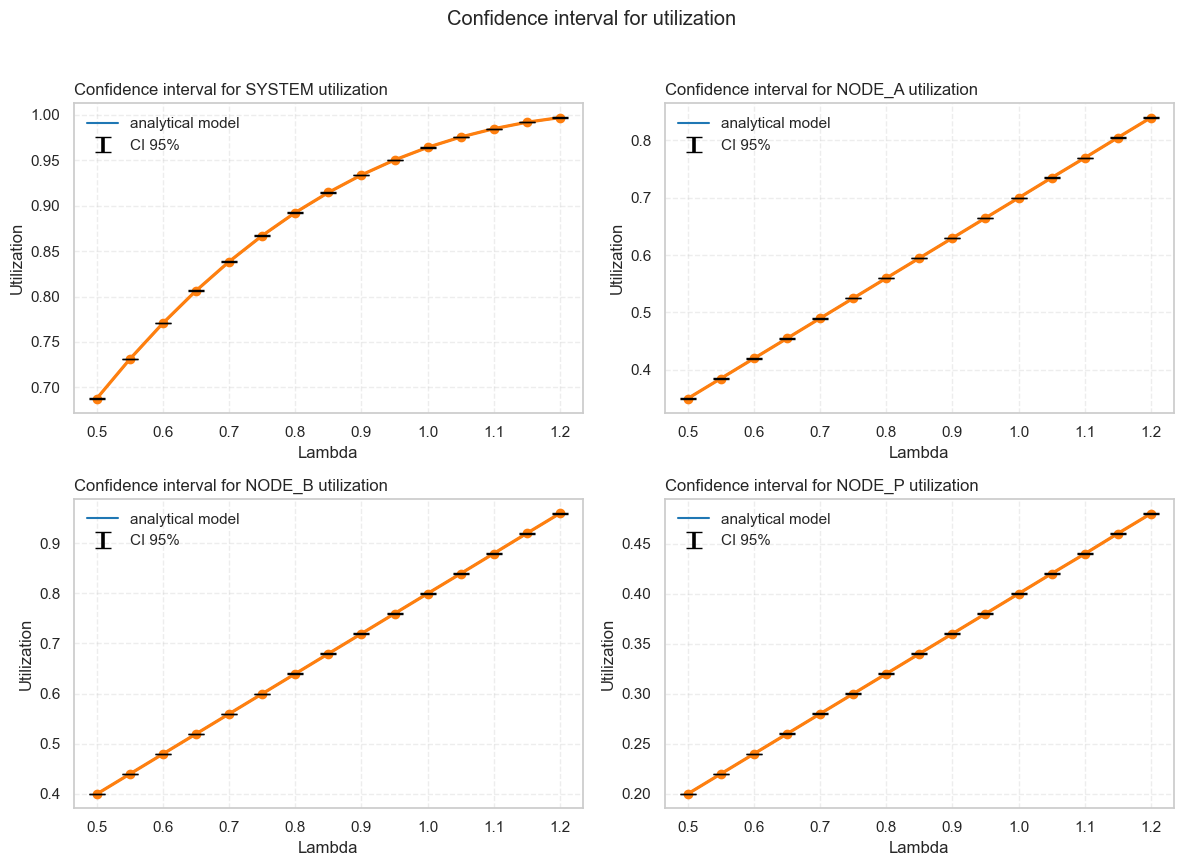

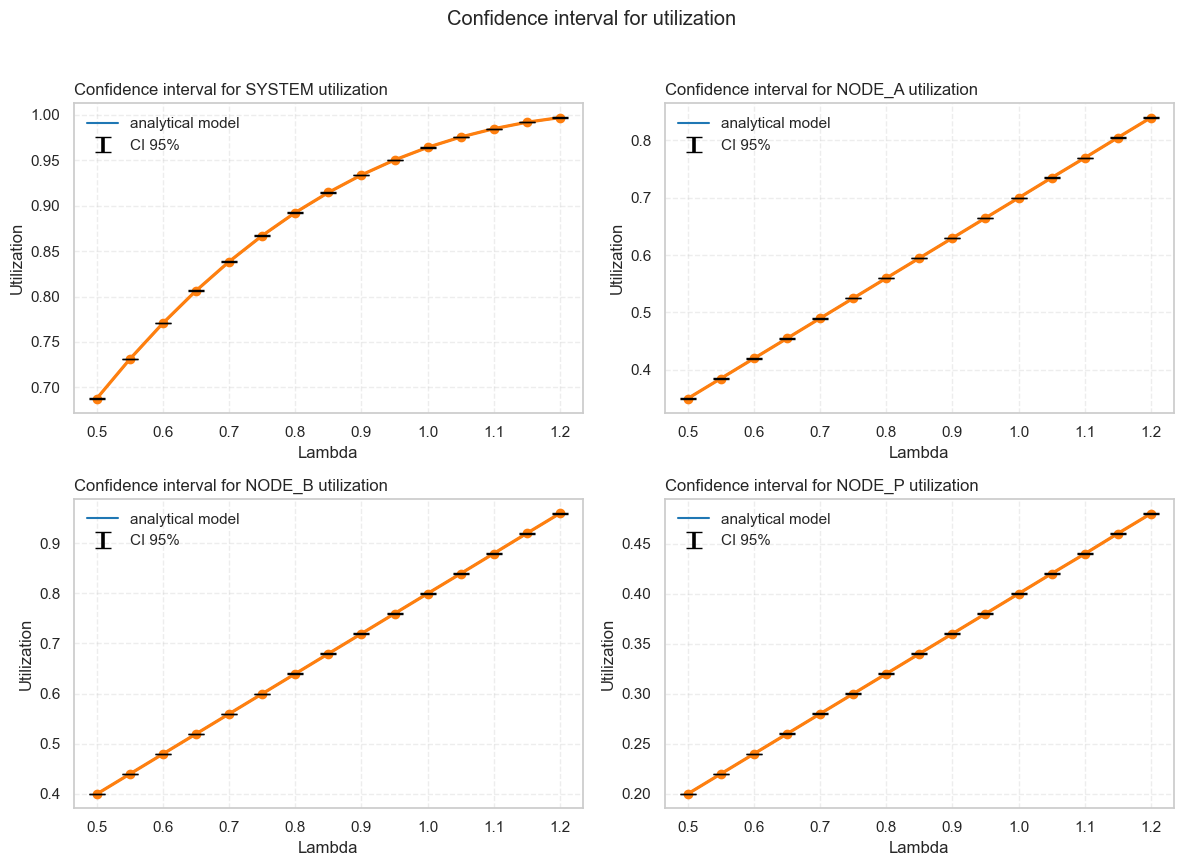

In [60]:
# df_all già pronto
plot_utilization_banded(
    df_all,
    conf=0.95,
    ci_design_effect=12.0,  # usato solo quando per qualche λ hai 1 replica effettiva
    ci_fill=True,
    min_display_half=0.0,   # alza (es. 0.01) per barre visivamente più visibili
    node_order=["NODE_A","NODE_B","NODE_P"],  # opzionale
    figsize=(12,9)
)


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Normalizza dfs_conv in un unico DataFrame ---
def _ensure_conv_df(dfs_conv) -> pd.DataFrame:
    """
    Accetta: DataFrame, lista/tupla di DataFrame o path/CSV/dizionari, singolo dict/lista-record.
    Ritorna un unico DataFrame con almeno: scope, metric, value, num_departures (+ opzionale arrival_rate).
    """
    if isinstance(dfs_conv, pd.DataFrame):
        df = dfs_conv.copy()
    elif isinstance(dfs_conv, (list, tuple)):
        parts = []
        for x in dfs_conv:
            if isinstance(x, pd.DataFrame):
                parts.append(x)
            elif isinstance(x, (str, Path)):
                parts.append(pd.read_csv(x))
            elif isinstance(x, dict):
                parts.append(pd.DataFrame([x]))
            else:
                # prova come sequenza di record
                try:
                    parts.append(pd.DataFrame(x))
                except Exception as e:
                    raise TypeError(f"Elemento non supportato in dfs_conv: {type(x)}") from e
        if not parts:
            raise ValueError("dfs_conv è una lista vuota.")
        df = pd.concat(parts, ignore_index=True)
    elif isinstance(dfs_conv, dict):
        df = pd.DataFrame([dfs_conv])
    else:
        # ultima spiaggia: prova a costruire un DF
        df = pd.DataFrame(dfs_conv)

    # colonne minime
    required = {"scope", "metric", "value", "num_departures"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Mancano colonne in dfs_conv: {missing}")

    # forza i tipi numerici dove serve
    for c in ("value", "num_departures"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if "arrival_rate" in df.columns:
        df["arrival_rate"] = pd.to_numeric(df["arrival_rate"], errors="coerce")

    # ordina per sicurezza
    return df.sort_values(["scope", "metric", "num_departures"]).reset_index(drop=True)

# --- Costruzione serie temporale per una metrica (es. mean_population) ---
def transient_series_from_conv(dfs_conv,
                               scope: str,
                               metric: str = "mean_population",
                               arrival_rate: float | None = None,
                               downsample_every: int = 1,
                               ewma_span: int | None = 15) -> pd.DataFrame:
    """
    Ricostruisce il tempo t ≈ num_departures / throughput (stesso scope e snapshot),
    e ritorna una serie ordinata con colonne ['t','value','value_smooth'].
    """
    df = _ensure_conv_df(dfs_conv)

    # filtro per λ se presente
    if arrival_rate is not None and "arrival_rate" in df.columns:
        df = df[df["arrival_rate"].eq(arrival_rate)]

    df_metric = df[(df["scope"].eq(scope)) & (df["metric"].eq(metric))][["num_departures", "value"]].copy()
    if df_metric.empty:
        return pd.DataFrame(columns=["t","value","value_smooth"])

    df_thr = df[(df["scope"].eq(scope)) & (df["metric"].eq("throughput"))][["num_departures", "value"]].copy()
    df_thr = df_thr.rename(columns={"value": "throughput"}).sort_values("num_departures")

    # allinea per num_departures (tollerante)
    df_metric = df_metric.sort_values("num_departures")
    series = pd.merge_asof(df_metric, df_thr, on="num_departures", direction="nearest")

    # tempo ricostruito ed estetica
    series["t"] = series["num_departures"] / series["throughput"].replace(0, np.nan)
    series = series.dropna(subset=["t"]).sort_values("t")[["t", "value"]]

    # downsampling opzionale
    if downsample_every > 1 and len(series) > downsample_every:
        series = series.iloc[::downsample_every, :].reset_index(drop=True)

    # smoothing (solo per plot)
    if ewma_span is not None and len(series) > 3:
        series["value_smooth"] = series["value"].ewm(span=ewma_span, adjust=False).mean()
    else:
        series["value_smooth"] = series["value"]
    return series

def estimate_convergence(y: np.ndarray, x: np.ndarray, tail_frac: float = 0.2) -> dict:
    """Stima valore limite (media coda) e pendenza sulla coda (retta LS)."""
    n = len(x)
    if n == 0:
        return {"tail_mean": np.nan, "tail_std": np.nan, "slope": np.nan, "n_tail": 0}
    k0 = max(1, int(n * (1.0 - tail_frac)))
    xt, yt = x[k0:], y[k0:]
    A = np.vstack([xt, np.ones_like(xt)]).T
    slope, intercept = np.linalg.lstsq(A, yt, rcond=None)[0]
    return {
        "tail_mean": float(np.mean(yt)),
        "tail_std": float(np.std(yt, ddof=1)) if len(yt) > 1 else 0.0,
        "slope": float(slope),
        "intercept": float(intercept),
        "n_tail": int(len(yt))
    }

def plot_transient_population(dfs_conv,
                              scopes=("OVERALL", "NODE_A", "NODE_B", "NODE_P"),
                              *,
                              arrival_rate: float | None = None,
                              downsample_every: int = 5,
                              ewma_span: int | None = 25,
                              slope_tol: float = 1e-3,
                              title_prefix: str = "Transient of mean population"):
    """Plotta il transitorio per gli scope indicati, con stima convergenza sulla coda."""
    # se c'è più di un λ e non si filtra, prendo il min (per evitare mischioni)
    df_probe = _ensure_conv_df(dfs_conv)
    if arrival_rate is None and "arrival_rate" in df_probe.columns and df_probe["arrival_rate"].nunique() > 1:
        arrival_rate = float(df_probe["arrival_rate"].sort_values().iloc[0])

    nplots = len(scopes)
    nrows = 2 if nplots > 1 else 1
    ncols = int(np.ceil(nplots / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), squeeze=False)
    axes = axes.ravel()

    for ax, scope in zip(axes, scopes):
        series = transient_series_from_conv(
            dfs_conv, scope, metric="mean_population",
            arrival_rate=arrival_rate,
            downsample_every=downsample_every, ewma_span=ewma_span
        )
        if series.empty:
            ax.set_title(f"{scope}: nessun dato"); ax.axis("off"); continue

        x = series["t"].to_numpy(float)
        y = series["value"].to_numpy(float)
        ys = series["value_smooth"].to_numpy(float)

        info = estimate_convergence(ys, x, tail_frac=0.2)
        converges = (np.isfinite(info["slope"]) and abs(info["slope"]) < slope_tol)

        ax.plot(x, y, alpha=0.35, label="misura (raw)")
        ax.plot(x, ys, linewidth=2.0, label="EWMA", zorder=3)
        ax.axhline(info["tail_mean"], linestyle="--",
                   color=("tab:green" if converges else "tab:red"),
                   alpha=0.85, linewidth=1.8,
                   label=("stima limite" if converges else "trend non stazionario"))

        subtitle = f"{scope} — {'converge' if converges else 'non converge'}"
        subtitle += f" (tail≈{info['tail_mean']:.3g}, slope≈{info['slope']:.2e})"
        ax.set_title(subtitle)
        ax.set_xlabel("Tempo simulazione (s)")
        ax.set_ylabel("Mean population")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    if arrival_rate is not None:
        fig.suptitle(f"{title_prefix} (λ={arrival_rate:g})")
    else:
        fig.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()


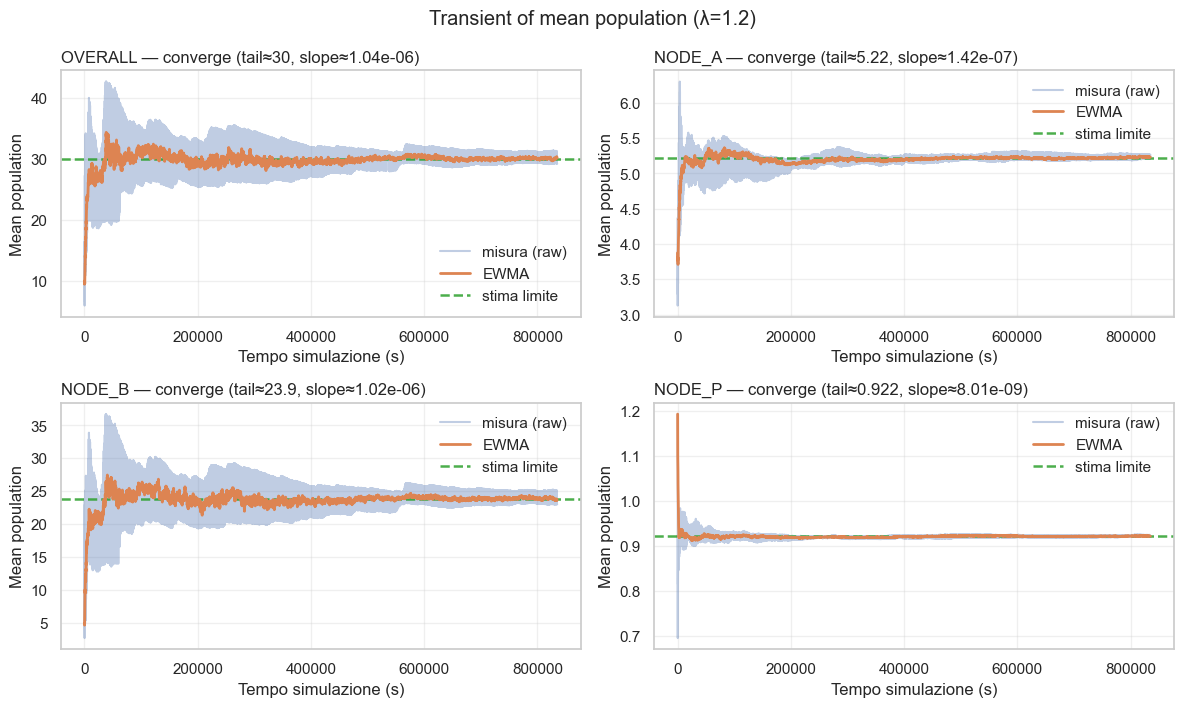

In [62]:
#plot_transient_population(dfs_conv, scopes=("OVERALL","NODE_A","NODE_B","NODE_P"))
# oppure, se dfs_conv contiene più λ e vuoi quello specifico:
"""
df_1_2 = []
for d in dfs_conv:
    df_1_2.append(d[d['arrival_rate']==1.2])
"""
plot_transient_population(dfs_conv, arrival_rate=1.2)


In [63]:
def plot_transient_response_time(dfs_conv,
                                 scopes=("OVERALL", "NODE_A", "NODE_B", "NODE_P"),
                                 *,
                                 arrival_rate: float | None = None,
                                 downsample_every: int = 5,
                                 ewma_span: int | None = 25,
                                 slope_tol: float = 1e-3,
                                 title_prefix: str = "Transient of mean response time"):
    """
    Plotta il transitorio del **tempo di risposta medio** (mean_response_time) per gli scope indicati,
    ricostruendo l'asse X in **secondi** via t ≈ num_departures / throughput.
    Richiede le stesse colonne di dfs_conv: [scope, metric, value, num_departures, (facoltativo) arrival_rate].
    """
    # se c'è più di un λ e non si filtra, prendo il min per evitare di mischiare run diversi
    df_probe = _ensure_conv_df(dfs_conv)
    if arrival_rate is None and "arrival_rate" in df_probe.columns and df_probe["arrival_rate"].nunique() > 1:
        arrival_rate = float(df_probe["arrival_rate"].sort_values().iloc[0])

    nplots = len(scopes)
    nrows = 2 if nplots > 1 else 1
    ncols = int(np.ceil(nplots / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows), squeeze=False)
    axes = axes.ravel()

    for ax, scope in zip(axes, scopes):
        # --- costruisce la serie temporale per mean_response_time ---
        series = transient_series_from_conv(
            dfs_conv, scope, metric="mean_response_time",
            arrival_rate=arrival_rate,
            downsample_every=downsample_every, ewma_span=ewma_span
        )
        if series.empty:
            ax.set_title(f"{scope}: nessun dato"); ax.axis("off"); continue

        x = series["t"].to_numpy(float)           # tempo simulazione (s)
        y = series["value"].to_numpy(float)       # misura "grezza"
        ys = series["value_smooth"].to_numpy(float)  # EWMA (lisciata)

        # --- stima della convergenza sulla coda (retta LS) ---
        info = estimate_convergence(ys, x, tail_frac=0.2)
        converges = (np.isfinite(info["slope"]) and abs(info["slope"]) < slope_tol)

        # --- plot ---
        ax.plot(x, y, alpha=0.35, label="misura (raw)")
        ax.plot(x, ys, linewidth=2.0, label="EWMA", zorder=3)
        ax.axhline(info["tail_mean"], linestyle="--",
                   color=("tab:green" if converges else "tab:red"),
                   alpha=0.85, linewidth=1.8,
                   label=("stima limite" if converges else "trend non stazionario"))

        subtitle = f"{scope} — {'converge' if converges else 'non converge'}"
        subtitle += f" (tail≈{info['tail_mean']:.3g}s, slope≈{info['slope']:.2e})"
        ax.set_title(subtitle)
        ax.set_xlabel("Tempo simulazione (s)")
        ax.set_ylabel("Mean response time (s)")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    if arrival_rate is not None:
        fig.suptitle(f"{title_prefix} (λ={arrival_rate:g})")
    else:
        fig.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()


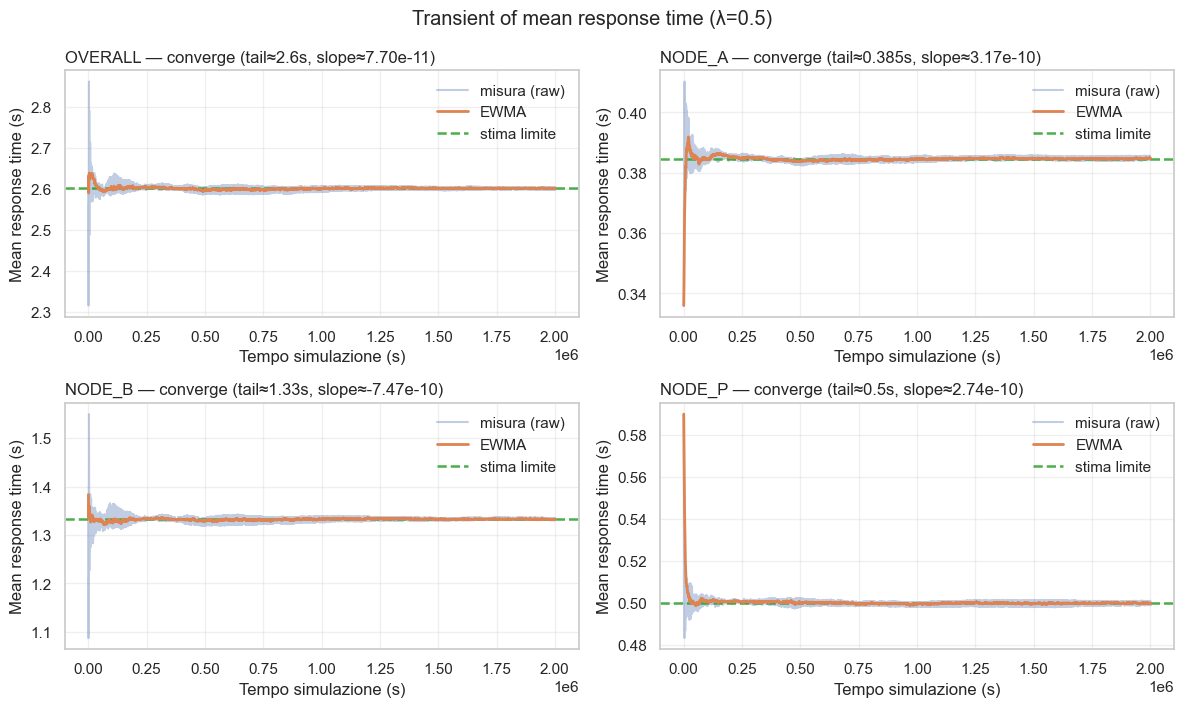

In [64]:
# Un solo run (o dfs_conv contiene un solo λ):
plot_transient_response_time(dfs_conv)

# Se dfs_conv contiene più λ e vuoi filtrare:
#plot_transient_response_time(dfs_conv, arrival_rate=0.95)

# Parametri per grafico più liscio:
# plot_transient_response_time(dfs_conv, ewma_span=45, downsample_every=3)


In [65]:
# ====================== Hyper-Exp: metriche vs probability (da df_all) ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Pulizia/normalizzazione: usa df_all già presente ---
def _clean_prob_df(df_all: pd.DataFrame) -> pd.DataFrame:
    df = df_all.copy()

    # elimina eventuali colonne spurie (es. 'Unnamed: 0')
    drop_cols = [c for c in df.columns if str(c).startswith("Unnamed") or str(c).strip()==""]
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")

    # assicurati che esista 'probability' (se l'hai chiamata diversamente prova a rinominare)
    if "probability" not in df.columns:
        # tenta colonne contenenti 'prob'
        cand = [c for c in df.columns if "prob" in c.lower()]
        if cand:
            df = df.rename(columns={cand[0]: "probability"})
        else:
            raise ValueError("Manca la colonna 'probability' nei CSV.")

    # cast numerici delle colonne rilevanti
    num_cols = ["arrival_rate","mean_response_time","std_response_time",
                "mean_population","std_population","throughput","utilization",
                "probability"]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # tieni solo righe con probability valida
    df = df.dropna(subset=["probability"])
    df = df[(df["probability"] >= 0.0) & (df["probability"] <= 1.0)]

    # ordina per sicurezza
    if "scope" in df.columns:
        df = df.sort_values(["scope","probability"]).reset_index(drop=True)
    else:
        df = df.sort_values(["probability"]).reset_index(drop=True)
    return df

# --- Aggregazione su repliche (seed): mean + CI 95% per ogni p ---
def aggregate_vs_probability(df_all: pd.DataFrame,
                             metric: str,
                             scope: str,
                             arrival_rate: float | None = None,
                             conf: float = 0.95) -> pd.DataFrame:
    """
    Ritorna un DF con colonne: x(probability), y(mean), std, n, sem, ci_lo, ci_hi
    filtrando per scope e (opzionale) arrival_rate.
    """
    df = _clean_prob_df(df_all)

    if arrival_rate is not None and "arrival_rate" in df.columns:
        df = df[df["arrival_rate"].eq(arrival_rate)]
    elif "arrival_rate" in df.columns:
        uniq = df["arrival_rate"].dropna().unique()
        if len(uniq) > 1:
            # se non specificato, prendi il primo per evitare mix di λ
            df = df[df["arrival_rate"].eq(uniq[0])]

    df = df[df["scope"].eq(scope)].dropna(subset=["probability", metric]).copy()
    if df.empty:
        return pd.DataFrame(columns=["x","y","std","n","sem","ci_lo","ci_hi"])

    g = (df.groupby("probability", as_index=False)[metric]
           .agg(["mean","std","count"])
           .reset_index()
           .rename(columns={"count":"n"}))

    # CI gaussiane (n≈5 repliche → ok come stima pratica)
    z = 1.96 if abs(conf - 0.95) < 1e-9 else 1.96
    g["sem"] = g["std"] / np.sqrt(g["n"].clip(lower=1))
    g["ci_lo"] = g["mean"] - z * g["sem"]
    g["ci_hi"] = g["mean"] + z * g["sem"]

    g = g.rename(columns={"probability": "x", "mean": "y"})
    for c in ["x","y","ci_lo","ci_hi"]:
        g[c] = pd.to_numeric(g[c], errors="coerce")
    return g.sort_values("x").reset_index(drop=True)

# --- Plot helper (una figura per scope, niente seaborn/colori fissi) ---
def _plot_one(ax, agg_df, *, ylab, title):
    x = agg_df["x"].to_numpy(float)
    y = agg_df["y"].to_numpy(float)
    lo = agg_df["ci_lo"].to_numpy(float)
    hi = agg_df["ci_hi"].to_numpy(float)

    ax.fill_between(x, lo, hi, alpha=0.15, linewidth=0, label="CI 95%")
    ax.plot(x, y, "o-", linewidth=2.0, label="mean")
    ax.set_xlabel("Hyperexp mix probability p")
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()

def plot_hyperexp_sensitivity(df_all: pd.DataFrame,
                              *,
                              arrival_rate: float | None = None,
                              scopes=("OVERALL","NODE_A","NODE_B","NODE_P"),
                              show_rt: bool = True,
                              show_pop: bool = True):
    lam_txt = ""
    if arrival_rate is not None:
        lam_txt = f" (λ={arrival_rate:g})"
    elif "arrival_rate" in df_all.columns and df_all["arrival_rate"].notna().any():
        uniq = df_all["arrival_rate"].dropna().unique()
        if len(uniq) == 1:
            lam_txt = f" (λ={float(uniq[0]):g})"

    # 1) Response time vs p
    if show_rt:
        for sc in scopes:
            agg = aggregate_vs_probability(df_all, "mean_response_time", sc, arrival_rate=arrival_rate, conf=0.95)
            fig, ax = plt.subplots(figsize=(7,4))
            title = f"{sc.replace('NODE_','Server ').replace('OVERALL','SYSTEM')} — Response time vs hyperexp p{lam_txt}"
            _plot_one(ax, agg, ylab="Mean response time (s)", title=title)
            plt.tight_layout(); plt.show()

    # 2) Population vs p
    if show_pop:
        for sc in scopes:
            agg = aggregate_vs_probability(df_all, "mean_population", sc, arrival_rate=arrival_rate, conf=0.95)
            fig, ax = plt.subplots(figsize=(7,4))
            title = f"{sc.replace('NODE_','Server ').replace('OVERALL','SYSTEM')} — Population vs hyperexp p{lam_txt}"
            _plot_one(ax, agg, ylab="Mean population", title=title)
            plt.tight_layout(); plt.show()


In [66]:
# Caso tipico: df_all contiene i 5 CSV (repliche) per vari valori di p e λ fisso
plot_hyperexp_sensitivity(df_all, arrival_rate=1.2)

# Solo tempi di risposta:
# plot_hyperexp_sensitivity(df_all, arrival_rate=1.2, show_pop=False)

# Solo popolazione:
# plot_hyperexp_sensitivity(df_all, arrival_rate=1.2, show_rt=False)

# Se in df_all ci sono più λ e vuoi lasciare che il codice scelga il primo:
# plot_hyperexp_sensitivity(df_all)


ValueError: Manca la colonna 'probability' nei CSV.

In [ ]:
# plot_mean_rt_by_seed_single_line.py
# Requisiti: pandas, matplotlib, numpy
# pip install pandas matplotlib

import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(".output_simulation")
SMOOTH = True        # True: interpola su griglia fine; False: solo i punti unici (senza marker)
GRID_POINTS = 200    # risoluzione della griglia per l'interpolazione

files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
if not files:
    raise SystemExit(f"Nessun CSV trovato in {DATA_DIR.resolve()}")

seed_re = re.compile(r"seed(\d+)")
prob_re = re.compile(r"prob([0-9\.eE+-]+)")

def parse_seed_prob(fname: str):
    s = seed_re.search(fname)
    p = prob_re.search(fname)
    if not (s and p):
        raise ValueError(f"Impossibile estrarre seed/prob da: {fname}")
    return int(s.group(1)), float(p.group(1))

def extract_mean_rt(df: pd.DataFrame) -> float:
    cols = list(df.columns)
    lcols = [c.lower().strip() for c in cols]
    preferred = "mean_reponse_time"
    for pat in preferred:
        for i, c in enumerate(lcols):
            if re.search(pat, c):
                ser = pd.to_numeric(df[cols[i]], errors="coerce")
                return float(ser.dropna().mean())

    for i, c in enumerate(lcols):
        if any(k in c for k in ["response", "resp_time", "rt", "r_time"]):
            ser = pd.to_numeric(df[cols[i]], errors="coerce")
            if ser.notna().any():
                return float(ser.dropna().mean())

    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) == 1:
        return float(df[num_cols[0]].mean())

    for c in cols:
        ser = pd.to_numeric(df[c], errors="coerce")
        if ser.notna().any():
            return float(ser.dropna().mean())

    raise ValueError("Colonna per Mean Response Time non trovata.")

rows = []
for f in files:
    try:
        seed, prob = parse_seed_prob(Path(f).name)
    except Exception as e:
        print(f"[skip] {f}: {e}"); continue

    try:
        try:
            df = pd.read_csv(f)
        except Exception:
            df = pd.read_csv(f, sep=';')
        mrt = extract_mean_rt(df)
        rows.append((seed, round(prob, 3), mrt))
    except Exception as e:
        print(f"[skip] {f}: {e}")

if not rows:
    raise SystemExit("Nessun dato utile estratto dai CSV.")

data = pd.DataFrame(rows, columns=["seed", "prob", "mean_rt"])

# 1) Collassa repliche allo stesso p: un solo valore medio per seed,p
agg = (data.groupby(["seed", "prob"], as_index=False)["mean_rt"].mean()
            .sort_values(["seed","prob"]))

plt.figure(figsize=(10,5))
for seed, g in agg.groupby("seed"):
    g = g.sort_values("prob")
    x = g["prob"].to_numpy()
    y = g["mean_rt"].to_numpy()

    if SMOOTH and len(x) >= 2:
        # interpola su una griglia fine per una curva unica “liscia”
        x_grid = np.linspace(x.min(), x.max(), GRID_POINTS)
        y_grid = np.interp(x_grid, x, y)
        plt.plot(x_grid, y_grid, linewidth=2, label=f"seed {seed}")
    else:
        # nessun marker, solo linea unica sui p disponibili
        plt.plot(x, y, linewidth=2, label=f"seed {seed}")

plt.xlabel("Probability p")
plt.ylabel("Mean Response Time")
plt.title("Mean Response Time vs p per seed")
plt.grid(True, alpha=0.3)
plt.legend(title="Seeds", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


# (opzionale) stampa tabellina riassuntiva
summary = (data
           .sort_values(["seed","prob"])
           .pivot_table(index="prob", columns="seed", values="mean_rt", aggfunc="mean"))
print("\nTabella (Mean RT per p, colonne=seed):")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))





In [ ]:
#plot_ci_mean_rt_by_p.py
# Requisiti: pandas, matplotlib, numpy
# pip install pandas matplotlib

import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(".output_simulation")
files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
if not files:
    raise SystemExit(f"Nessun CSV trovato in {DATA_DIR.resolve()}")

seed_re = re.compile(r"seed(\d+)")
prob_re = re.compile(r"prob([0-9\.eE+-]+)")

def parse_seed_prob(fname: str):
    s = seed_re.search(fname)
    p = prob_re.search(fname)
    if not (s and p):
        raise ValueError(f"Impossibile estrarre seed/prob da: {fname}")
    return int(s.group(1)), float(p.group(1))

def extract_mean_rt(df: pd.DataFrame) -> float:
    """
    Estrae un 'Mean Response Time' robustamente:
    - prova varie nomenclature comuni
    - altrimenti prova colonne con 'response'/'rt'
    - fallback: prima colonna numerica media
    """
    cols = list(df.columns)
    lcols = [c.lower().strip() for c in cols]
    preferred = "mean_response_time"
    for pat in preferred:
        for i, c in enumerate(lcols):
            if re.search(pat, c):
                ser = pd.to_numeric(df[cols[i]], errors="coerce")
                return float(ser.dropna().mean())

    for i, c in enumerate(lcols):
        if any(k in c for k in ["response", "resp_time", "rt", "r_time"]):
            ser = pd.to_numeric(df[cols[i]], errors="coerce")
            if ser.notna().any():
                return float(ser.dropna().mean())

    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    if num_cols:
        return float(df[num_cols[0]].mean())

    raise ValueError("Colonna per Mean Response Time non trovata.")

# carica tutti i punti (seed, p) -> mean_rt
rows = []
for f in files:
    try:
        seed, prob = parse_seed_prob(Path(f).name)
    except Exception as e:
        print(f"[skip nome] {f}: {e}")
        continue
    try:
        try:
            df = pd.read_csv(f)
        except Exception:
            df = pd.read_csv(f, sep=';')
        mrt = extract_mean_rt(df)
        rows.append((round(prob, 3), seed, mrt))
    except Exception as e:
        print(f"[skip dati] {f}: {e}")

if not rows:
    raise SystemExit("Nessun dato utile estratto dai CSV.")

data = pd.DataFrame(rows, columns=["prob", "seed", "mean_rt"])


def t_crit(n: int) -> float:
    if n <= 1:  # CI non definito, restituisco infinito per dare banda enorme
        return float("inf")
    # prendi valore tabellato se esiste, altrimenti interpola grezzamente o usa z
    if n in _TCRIT_95:
        return _TCRIT_95[n]
    if n < 30:
        # interpola tra i due più vicini (grossolano ma ok)
        below = max(k for k in _TCRIT_95 if k < n)
        above = min(k for k in _TCRIT_95 if k > n)
        w = (n - below) / (above - below)
        return _TCRIT_95[below] * (1 - w) + _TCRIT_95[above] * w
    return 1.96  # ~N(0,1) per n grandi

summary = (data
           .groupby("prob")
           .agg(n=("mean_rt","count"),
                mean=("mean_rt","mean"),
                std=("mean_rt","std"))
           .reset_index())

summary["sem"] = summary["std"] / np.sqrt(summary["n"])
summary["tcrit"] = summary["n"].apply(t_crit)
summary["halfwidth"] = summary["tcrit"] * summary["sem"]

# ordina per p
summary = summary.sort_values("prob")

# ---- Plot ----
plt.figure(figsize=(9,5))
x = summary["prob"].to_numpy()
m = summary["mean"].to_numpy()
h = summary["halfwidth"].to_numpy()

plt.plot(x, m, linewidth=2, label="Mean across seeds")
plt.fill_between(x, m - h, m + h, alpha=0.25, label="95% CI")
plt.xlabel("Probability p")
plt.ylabel("Mean Response Time")
plt.title("Mean Response Time vs p con CI 95% (tra seed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (opzionale) stampa tabella
print("\nRiassunto (p, n, mean, CI±):")
print(summary[["prob","n","mean","halfwidth"]]
      .to_string(index=False, float_format=lambda v: f"{v:.4f}"))